# Differentially Expressed Genes Analysis
This notebook aims to interrogate and investigate the differential gene expression results to better understand what is changing between the different comparisons we have, characterizing similarities and differences where possible.

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import os
import statistics as stats
import seaborn as sns
import ast
FIG_PATH = '/group/ll005/cmcphan/notebooks/analysis/results/figures/'

Set up dictionaries for converting between ENSEMBL IDs and gene symbols in the Sepp datasets

In [2]:
herring_human = ad.read_h5ad('/group/ll005/cmcphan/herring_data/Processed_data_RNA-all_full-counts-and-downsampled-CPM.h5ad')
sepp_human = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_human_normal_reduced.h5ad')
sepp_mouse = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_mouse_normal_reduced.h5ad')
sepp_opossum = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_opossum_normal_reduced.h5ad')

In [4]:
sepp_id_to_symbol = {}
for data in [sepp_human, sepp_mouse, sepp_opossum]:
    for var in data.var.index:
        symbol = data.var['gene_symbol'][var]
        if symbol == '':
            sepp_id_to_symbol[var] = None
        else:
            sepp_id_to_symbol[var] = symbol
sepp_id_to_symbol

{'ENSG00000237094': None,
 'ENSG00000230021': None,
 'ENSG00000248527': 'MTATP6P1',
 'ENSG00000237491': 'LINC01409',
 'ENSG00000228794': 'LINC01128',
 'ENSG00000272438': None,
 'ENSG00000188976': 'NOC2L',
 'ENSG00000272512': None,
 'ENSG00000188290': 'HES4',
 'ENSG00000187608': 'ISG15',
 'ENSG00000188157': 'AGRN',
 'ENSG00000131591': 'C1orf159',
 'ENSG00000162571': 'TTLL10',
 'ENSG00000078808': 'SDF4',
 'ENSG00000176022': 'B3GALT6',
 'ENSG00000160087': 'UBE2J2',
 'ENSG00000230415': 'LINC01786',
 'ENSG00000162572': 'SCNN1D',
 'ENSG00000131584': 'ACAP3',
 'ENSG00000169972': 'PUSL1',
 'ENSG00000127054': 'INTS11',
 'ENSG00000224051': 'CPTP',
 'ENSG00000107404': 'DVL1',
 'ENSG00000175756': 'AURKAIP1',
 'ENSG00000221978': 'CCNL2',
 'ENSG00000224870': 'MRPL20-AS1',
 'ENSG00000242485': 'MRPL20',
 'ENSG00000215915': 'ATAD3C',
 'ENSG00000160072': 'ATAD3B',
 'ENSG00000197785': 'ATAD3A',
 'ENSG00000160075': 'SSU72',
 'ENSG00000272106': None,
 'ENSG00000197530': 'MIB2',
 'ENSG00000248333': 'CDK11B'

In [5]:
# Invert conversion dictionary so we have the opposite conversion as well
sepp_symbol_to_id = {s: i for i, s in sepp_id_to_symbol.items()}
sepp_symbol_to_id

{None: 'ENSMODG00000027921',
 'MTATP6P1': 'ENSG00000248527',
 'LINC01409': 'ENSG00000237491',
 'LINC01128': 'ENSG00000228794',
 'NOC2L': 'ENSMODG00000018641',
 'HES4': 'ENSG00000188290',
 'ISG15': 'ENSG00000187608',
 'AGRN': 'ENSG00000188157',
 'C1orf159': 'ENSG00000131591',
 'TTLL10': 'ENSG00000162571',
 'SDF4': 'ENSMODG00000016449',
 'B3GALT6': 'ENSG00000176022',
 'UBE2J2': 'ENSG00000160087',
 'LINC01786': 'ENSG00000230415',
 'SCNN1D': 'ENSG00000162572',
 'ACAP3': 'ENSG00000131584',
 'PUSL1': 'ENSG00000169972',
 'INTS11': 'ENSMODG00000006290',
 'CPTP': 'ENSMODG00000006296',
 'DVL1': 'ENSMODG00000006382',
 'AURKAIP1': 'ENSG00000175756',
 'CCNL2': 'ENSG00000221978',
 'MRPL20-AS1': 'ENSG00000224870',
 'MRPL20': 'ENSG00000242485',
 'ATAD3C': 'ENSG00000215915',
 'ATAD3B': 'ENSG00000160072',
 'ATAD3A': 'ENSMODG00000006603',
 'SSU72': 'ENSG00000160075',
 'MIB2': 'ENSMODG00000006713',
 'CDK11B': 'ENSG00000248333',
 'SLC35E2B': 'ENSMODG00000006795',
 'CDK11A': 'ENSG00000008128',
 'SLC35E2A': 

Find genes that are expressed in all groups

In [5]:
herring_symbols = herring_human.var.index.tolist()
herring_symbols = [g.upper() for g in herring_symbols]
sepp_human_symbols = sepp_human.var['gene_symbol'].tolist()
sepp_human_symbols = [g.upper() for g in sepp_human_symbols]
sepp_mouse_symbols = sepp_mouse.var['gene_symbol'].tolist()
sepp_mouse_symbols = [g.upper() for g in sepp_mouse_symbols]
sepp_opossum_symbols = sepp_opossum.var['gene_symbol'].tolist()
sepp_opossum_symbols = [g.upper() for g in sepp_opossum_symbols]
common_genes = [g for g in herring_symbols if g in sepp_human_symbols]
common_genes = [g for g in common_genes if g in sepp_mouse_symbols]
common_genes = [g for g in common_genes if g in sepp_opossum_symbols]
len(common_genes)

7634

Look at what's changing in each of our groups. Limit to a fairly strict log fold cutoff to see what's changing most drastically.

In [6]:
dges = {}
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/herring_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/sepp_human_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/sepp_mouse_fetal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_neonatal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_adolescence_infancy_']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp']
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
cell_types = ['PN', 'IN']
for p, d, c in zip(paths, datasets, comps):
    comp_dges = {}
    for t in cell_types:
        dge = pd.read_csv(str(p+t), index_col=0)
        if d == 'sepp':
            dge['gene_symbol'] = [sepp_id_to_symbol[g].upper() if sepp_id_to_symbol[g] is not None else g for g in dge.index.tolist()]
        elif d == 'herring':
            dge['gene_symbol'] = [g.upper() for g in dge.index.to_list()]
        dge = dge.query('padj <= 0.05')
        dge_up = dge.query('log2FoldChange >= 3')
        dge_down = dge.query('log2FoldChange <= -3')
        comp_dges[t] = {'up': dge_up, 'down': dge_down}
    dges[c] = comp_dges
dges

{'herring_human_birth': {'PN': {'up':                   baseMean  log2FoldChange     lfcSE       stat        pvalue  \
   PLEKHN1          35.676728        3.691518  1.188071   3.107152  1.888989e-03   
   RP11-547D24.1    16.171967        3.799786  1.018418   3.731068  1.906698e-04   
   GABRD           898.719112        5.253109  0.488788  10.747205  6.108448e-27   
   TNFRSF14         67.366253        3.691165  0.606265   6.088364  1.140701e-09   
   RP11-154H17.1   769.117306        3.739627  0.513757   7.278987  3.363349e-13   
   ...                    ...             ...       ...        ...           ...   
   AF064858.8       82.243374        3.263385  0.726604   4.491283  7.079545e-06   
   AF064858.11       8.919445        4.528601  1.589274   2.849478  4.379102e-03   
   RSPH1           355.034958        4.153862  0.452551   9.178763  4.360710e-20   
   TRPM2          1165.116742        3.902862  0.479495   8.139521  3.968434e-16   
   AC145212.1       29.014021        3.33

In [8]:
# Look at similarity in significant DEGs with a strong log fold change across comparisons
# Impose limit on the number of genes considered to keep baseline consistent - use the top 50
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
df_matrix = []
index = []
for y in range(0, len(comps)): # Each row gets made one by one, so the first index here is actually the y axis
    comp_y = comps[y]
    for cty in ['PN', 'IN']:
        props = []
        index.append(str(comp_y+'_'+cty))
        for x in range(0, len(comps)):
            comp_x = comps[x]
            for ctx in ['PN', 'IN']:
                if x == y:
                    if ctx == cty:
                        props.append(1) # Perfect overlap with self
                    elif ctx == 'PN' and cty == 'IN':
                        genes_x = dges[comp_x][ctx]['down']['gene_symbol'].values[:50]
                        genes_y = dges[comp_y][cty]['down']['gene_symbol'].values[:50]
                        overlap = [g for g in genes_x if g in genes_y]
                        try:
                            props.append(len(overlap)/len(genes_x))
                        except ZeroDivisionError:
                            props.append(0)
                    elif ctx == 'IN' and cty == 'PN':
                        genes_x = dges[comp_x][ctx]['up']['gene_symbol'].values[:50]
                        genes_y = dges[comp_y][cty]['up']['gene_symbol'].values[:50]
                        overlap = [g for g in genes_x if g in genes_y]
                        try:
                            props.append(len(overlap)/len(genes_x))
                        except ZeroDivisionError:
                            props.append(0)
                elif x > y: # Top half is upregulated results
                        genes_x = dges[comp_x][ctx]['up']['gene_symbol'].values[:50]
                        genes_y = dges[comp_y][cty]['up']['gene_symbol'].values[:50]
                        overlap = [g for g in genes_x if g in genes_y]
                        try:
                            props.append(len(overlap)/len(genes_x))
                        except ZeroDivisionError:
                            props.append(0)
                elif x < y: # Bottom half is downregulated results
                    genes_x = dges[comp_x][ctx]['down']['gene_symbol'].values[:50]
                    genes_y = dges[comp_y][cty]['down']['gene_symbol'].values[:50]
                    overlap = [g for g in genes_x if g in genes_y]
                    try:
                        props.append(len(overlap)/len(genes_x))
                    except ZeroDivisionError:
                        props.append(0)
        df_matrix.append(props)
overlaps = pd.DataFrame(df_matrix, index=index, columns=index)
overlaps

,herring_human_birth_PN,herring_human_birth_IN,sepp_human_birth_PN,sepp_human_birth_IN,sepp_mouse_birth_PN,sepp_mouse_birth_IN,sepp_opossum_neonatal_PN,sepp_opossum_neonatal_IN,sepp_opossum_eye_opening_PN,sepp_opossum_eye_opening_IN
herring_human_birth_PN,1.00,0.18,0.00,0.00,0.00,0.02,0.020000,0.00,0.00,0.02
herring_human_birth_IN,0.28,1.00,0.02,0.02,0.02,0.00,0.000000,0.02,0.00,0.02
sepp_human_birth_PN,0.06,0.08,1.00,0.16,0.00,0.00,0.000000,0.02,0.00,0.02
sepp_human_birth_IN,0.04,0.04,0.10,1.00,0.02,0.00,0.020000,0.04,0.00,0.02
sepp_mouse_birth_PN,0.00,0.02,0.00,0.00,1.00,0.26,0.020000,0.02,0.00,0.00
sepp_mouse_birth_IN,0.00,0.02,0.00,0.00,0.38,1.00,0.000000,0.04,0.00,0.00
sepp_opossum_neonatal_PN,0.00,0.00,0.00,0.00,0.00,0.00,1.000000,0.14,0.02,0.00
sepp_opossum_neonatal_IN,0.00,0.00,0.02,0.00,0.00,0.02,0.444444,1.00,0.02,0.00
sepp_opossum_eye_opening_PN,0.00,0.04,0.02,0.04,0.00,0.00,0.000000,0.00,1.00,0.14
sepp_opossum_eye_opening_IN,0.00,0.02,0.00,0.02,0.00,0.00,0.000000,0.00,0.14,1.00


<Axes: >

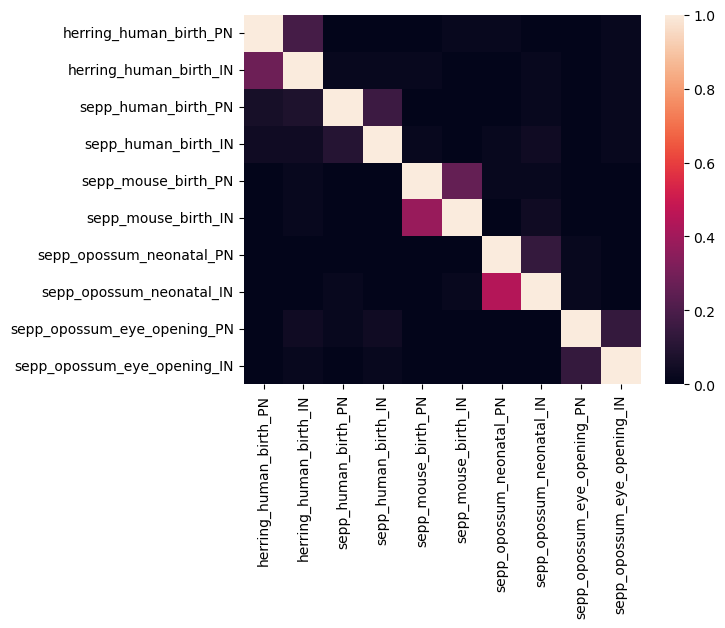

In [9]:
sns.heatmap(overlaps)

Extremely low overall concordance, to the point where no meaningful patterns can be discerned. Likely because of the fairly small proportion of genes which are shared by all datasets - most of the genes listed in each DEG list are not even present in the other datasets, procluding the possibility of meaningful comparison. Try again but limit to only those genes which are common to all datasets. Check for strongly differential genes which are common across datasets.

In [10]:
dges = {}
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/herring_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/sepp_human_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/sepp_mouse_fetal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_neonatal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_adolescence_infancy_']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp']
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
cell_types = ['PN', 'IN']
for p, d, c in zip(paths, datasets, comps):
    comp_dges = {}
    for t in cell_types:
        dge = pd.read_csv(str(p+t), index_col=0)
        if d == 'sepp':
            dge['gene_symbol'] = [sepp_id_to_symbol[g].upper() if sepp_id_to_symbol[g] is not None else g for g in dge.index.tolist()]
        elif d == 'herring':
            dge['gene_symbol'] = [g.upper() for g in dge.index.to_list()]
        dge = dge.loc[dge['gene_symbol'].isin(common_genes)] # Limit to only genes common to all datasets
        dge = dge.query('padj <= 0.05')
        dge_up = dge.query('log2FoldChange >= 3')
        dge_down = dge.query('log2FoldChange <= -3')
        comp_dges[t] = {'up': dge_up, 'down': dge_down}
    dges[c] = comp_dges
dges

{'herring_human_birth': {'PN': {'up':             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
   EXTL1     629.508956        3.677262  0.500623  7.345373  2.051863e-13   
   OPRD1     322.046882        3.794368  0.514571  7.373852  1.657678e-13   
   PTGER3   1247.816739        4.197018  0.506351  8.288756  1.144389e-16   
   MSH4      855.959564        3.700196  0.670166  5.521309  3.364834e-08   
   KCNJ10     98.979091        3.423386  1.148369  2.981085  2.872295e-03   
   ...              ...             ...       ...       ...           ...   
   AQP4      343.189598        3.712130  0.995727  3.728059  1.929601e-04   
   CCDC68    133.543859        3.558970  0.546066  6.517468  7.150404e-11   
   MBP      1606.435708        3.556707  0.522362  6.808891  9.835427e-12   
   LAMP5      70.024598        3.036317  0.788936  3.848624  1.187832e-04   
   SLC17A9    10.068140        4.704020  1.455530  3.231826  1.230021e-03   
   
                    padj gene_symbol 

In [11]:
# Look at similarity in significant DEGs with a strong log fold change across comparisons
# There are few genes in this grouping so no limit on number is imposed
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
df_matrix = []
index = []
for y in range(0, len(comps)): # Each row gets made one by one, so the first index here is actually the y axis
    comp_y = comps[y]
    for cty in ['PN', 'IN']:
        props = []
        index.append(str(comp_y+'_'+cty))
        for x in range(0, len(comps)):
            comp_x = comps[x]
            for ctx in ['PN', 'IN']:
                if x == y:
                    if ctx == cty:
                        props.append(1) # Perfect overlap with self
                    elif ctx == 'PN' and cty == 'IN':
                        genes_x = dges[comp_x][ctx]['down']['gene_symbol'].values[:50]
                        genes_y = dges[comp_y][cty]['down']['gene_symbol'].values[:50]
                        overlap = [g for g in genes_x if g in genes_y]
                        try:
                            props.append(len(overlap)/len(genes_x))
                        except ZeroDivisionError:
                            props.append(0)
                    elif ctx == 'IN' and cty == 'PN':
                        genes_x = dges[comp_x][ctx]['up']['gene_symbol'].values[:50]
                        genes_y = dges[comp_y][cty]['up']['gene_symbol'].values[:50]
                        overlap = [g for g in genes_x if g in genes_y]
                        try:
                            props.append(len(overlap)/len(genes_x))
                        except ZeroDivisionError:
                            props.append(0)
                elif x > y: # Top half is upregulated results
                        genes_x = dges[comp_x][ctx]['up']['gene_symbol'].values[:50]
                        genes_y = dges[comp_y][cty]['up']['gene_symbol'].values[:50]
                        overlap = [g for g in genes_x if g in genes_y]
                        try:
                            props.append(len(overlap)/len(genes_x))
                        except ZeroDivisionError:
                            props.append(0)
                elif x < y: # Bottom half is downregulated results
                    genes_x = dges[comp_x][ctx]['down']['gene_symbol'].values[:50]
                    genes_y = dges[comp_y][cty]['down']['gene_symbol'].values[:50]
                    overlap = [g for g in genes_x if g in genes_y]
                    try:
                        props.append(len(overlap)/len(genes_x))
                    except ZeroDivisionError:
                        props.append(0)
        df_matrix.append(props)
overlaps = pd.DataFrame(df_matrix, index=index, columns=index)
overlaps

,herring_human_birth_PN,herring_human_birth_IN,sepp_human_birth_PN,sepp_human_birth_IN,sepp_mouse_birth_PN,sepp_mouse_birth_IN,sepp_opossum_neonatal_PN,sepp_opossum_neonatal_IN,sepp_opossum_eye_opening_PN,sepp_opossum_eye_opening_IN
herring_human_birth_PN,1.00,0.160000,0.02,0.02,0.000000,0.033333,0.020833,0.06,0.02,0.035714
herring_human_birth_IN,0.30,1.000000,0.06,0.10,0.116279,0.033333,0.000000,0.02,0.04,0.035714
sepp_human_birth_PN,0.06,0.166667,1.00,0.22,0.116279,0.066667,0.020833,0.06,0.16,0.107143
sepp_human_birth_IN,0.08,0.100000,0.22,1.00,0.046512,0.000000,0.041667,0.06,0.04,0.142857
sepp_mouse_birth_PN,0.02,0.000000,0.00,0.00,1.000000,0.166667,0.062500,0.08,0.00,0.000000
sepp_mouse_birth_IN,0.00,0.000000,0.00,0.00,0.344828,1.000000,0.000000,0.12,0.00,0.000000
sepp_opossum_neonatal_PN,0.00,0.000000,0.00,0.00,0.000000,0.000000,1.000000,0.12,0.02,0.000000
sepp_opossum_neonatal_IN,0.00,0.000000,0.02,0.00,0.103448,0.136364,0.500000,1.00,0.00,0.000000
sepp_opossum_eye_opening_PN,0.06,0.100000,0.08,0.06,0.000000,0.000000,0.000000,0.00,1.00,0.250000
sepp_opossum_eye_opening_IN,0.06,0.133333,0.08,0.06,0.034483,0.045455,0.000000,0.00,0.14,1.000000


<Axes: >

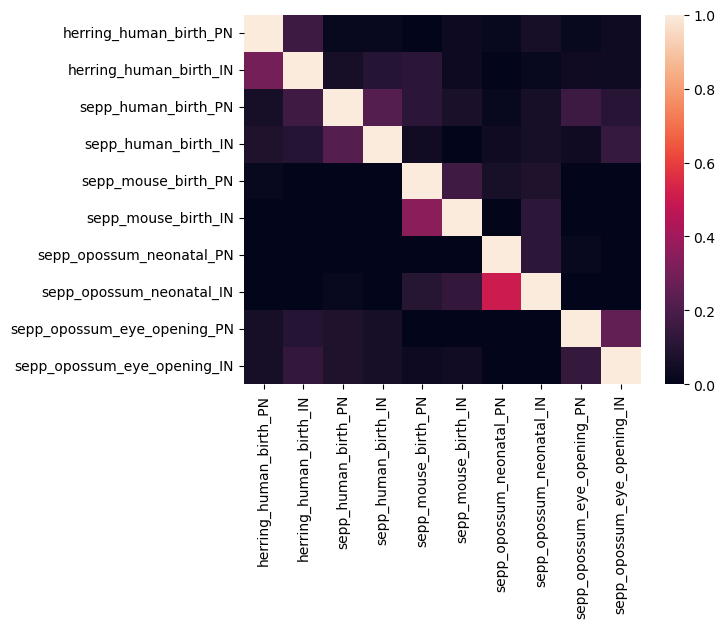

In [12]:
sns.heatmap(overlaps)

Overlap still overall very low, although it does appear that the opossum at eye opening overlaps more strongly in the downregulated genes with the human samples than around birth. Loosen log fold change cutoff

In [6]:
dges = {}
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/herring_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/sepp_human_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/sepp_mouse_fetal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_neonatal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_adolescence_infancy_']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp']
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
cell_types = ['PN', 'IN']
for p, d, c in zip(paths, datasets, comps):
    comp_dges = {}
    for t in cell_types:
        dge = pd.read_csv(str(p+t), index_col=0)
        if d == 'sepp':
            dge['gene_symbol'] = [sepp_id_to_symbol[g].upper() if sepp_id_to_symbol[g] is not None else g for g in dge.index.tolist()]
        elif d == 'herring':
            dge['gene_symbol'] = [g.upper() for g in dge.index.to_list()]
        dge = dge.loc[dge['gene_symbol'].isin(common_genes)] # Limit to only genes common to all datasets
        dge = dge.query('padj <= 0.05')
        dge_up = dge.query('log2FoldChange >= 1')
        dge_down = dge.query('log2FoldChange <= -1')
        comp_dges[t] = {'up': dge_up, 'down': dge_down}
    dges[c] = comp_dges
dges

{'herring_human_birth': {'PN': {'up':             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj  \
   AJAP1    6028.383301        1.765160  0.541188  3.261640  0.001108  0.012340   
   KCNAB2   1497.620826        2.122203  0.655592  3.237077  0.001208  0.013148   
   NMNAT1    415.108083        1.689245  0.523513  3.226747  0.001252  0.013415   
   DHRS3      68.680701        1.708726  0.607007  2.815003  0.004878  0.037481   
   ECE1     2647.858983        2.228067  0.643879  3.460379  0.000539  0.007132   
   ...              ...             ...       ...       ...       ...       ...   
   TEF       740.504719        2.324110  0.496742  4.678710  0.000003  0.000102   
   SHANK3   1410.925882        1.261348  0.459859  2.742901  0.006090  0.043929   
   NCAM2   29778.267679        1.641674  0.549432  2.987948  0.002809  0.024840   
   GRIK1    3446.495954        2.391916  0.546955  4.373148  0.000012  0.000342   
   KCNJ6   14412.221330        1.545320  0.474620  3

In [15]:
# Look at similarity in significant DEGs across comparisons
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
df_matrix = []
index = []
for y in range(0, len(comps)): # Each row gets made one by one, so the first index here is actually the y axis
    comp_y = comps[y]
    for cty in ['PN', 'IN']:
        props = []
        index.append(str(comp_y+'_'+cty))
        for x in range(0, len(comps)):
            comp_x = comps[x]
            for ctx in ['PN', 'IN']:
                if x == y:
                    if ctx == cty:
                        props.append(1) # Perfect overlap with self
                    elif ctx == 'PN' and cty == 'IN':
                        genes_x = dges[comp_x][ctx]['down']['gene_symbol'].values[:100]
                        genes_y = dges[comp_y][cty]['down']['gene_symbol'].values[:100]
                        overlap = [g for g in genes_x if g in genes_y]
                        try:
                            props.append(len(overlap)/len(genes_x))
                        except ZeroDivisionError:
                            props.append(0)
                    elif ctx == 'IN' and cty == 'PN':
                        genes_x = dges[comp_x][ctx]['up']['gene_symbol'].values[:100]
                        genes_y = dges[comp_y][cty]['up']['gene_symbol'].values[:100]
                        overlap = [g for g in genes_x if g in genes_y]
                        try:
                            props.append(len(overlap)/len(genes_x))
                        except ZeroDivisionError:
                            props.append(0)
                elif x > y: # Top half is upregulated results
                        genes_x = dges[comp_x][ctx]['up']['gene_symbol'].values[:100]
                        genes_y = dges[comp_y][cty]['up']['gene_symbol'].values[:100]
                        overlap = [g for g in genes_x if g in genes_y]
                        try:
                            props.append(len(overlap)/len(genes_x))
                        except ZeroDivisionError:
                            props.append(0)
                elif x < y: # Bottom half is downregulated results
                    genes_x = dges[comp_x][ctx]['down']['gene_symbol'].values[:100]
                    genes_y = dges[comp_y][cty]['down']['gene_symbol'].values[:100]
                    overlap = [g for g in genes_x if g in genes_y]
                    try:
                        props.append(len(overlap)/len(genes_x))
                    except ZeroDivisionError:
                        props.append(0)
        df_matrix.append(props)
overlaps = pd.DataFrame(df_matrix, index=index, columns=index)
overlaps

,herring_human_birth_PN,herring_human_birth_IN,sepp_human_birth_PN,sepp_human_birth_IN,sepp_mouse_birth_PN,sepp_mouse_birth_IN,sepp_opossum_neonatal_PN,sepp_opossum_neonatal_IN,sepp_opossum_eye_opening_PN,sepp_opossum_eye_opening_IN
herring_human_birth_PN,1.00,0.43,0.16,0.08,0.09,0.03,0.060000,0.02,0.02,0.05
herring_human_birth_IN,0.44,1.00,0.17,0.14,0.11,0.05,0.080000,0.02,0.05,0.08
sepp_human_birth_PN,0.16,0.21,1.00,0.23,0.08,0.02,0.050000,0.00,0.04,0.06
sepp_human_birth_IN,0.15,0.25,0.27,1.00,0.02,0.01,0.030000,0.00,0.03,0.09
sepp_mouse_birth_PN,0.04,0.02,0.06,0.05,1.00,0.35,0.090000,0.04,0.07,0.05
sepp_mouse_birth_IN,0.05,0.05,0.03,0.01,0.42,1.00,0.110000,0.06,0.03,0.03
sepp_opossum_neonatal_PN,0.02,0.03,0.01,0.02,0.12,0.11,1.000000,0.23,0.07,0.13
sepp_opossum_neonatal_IN,0.01,0.03,0.02,0.00,0.15,0.15,0.265306,1.00,0.20,0.06
sepp_opossum_eye_opening_PN,0.01,0.03,0.06,0.04,0.06,0.06,0.081633,0.11,1.00,0.27
sepp_opossum_eye_opening_IN,0.04,0.05,0.08,0.13,0.06,0.06,0.102041,0.09,0.17,1.00


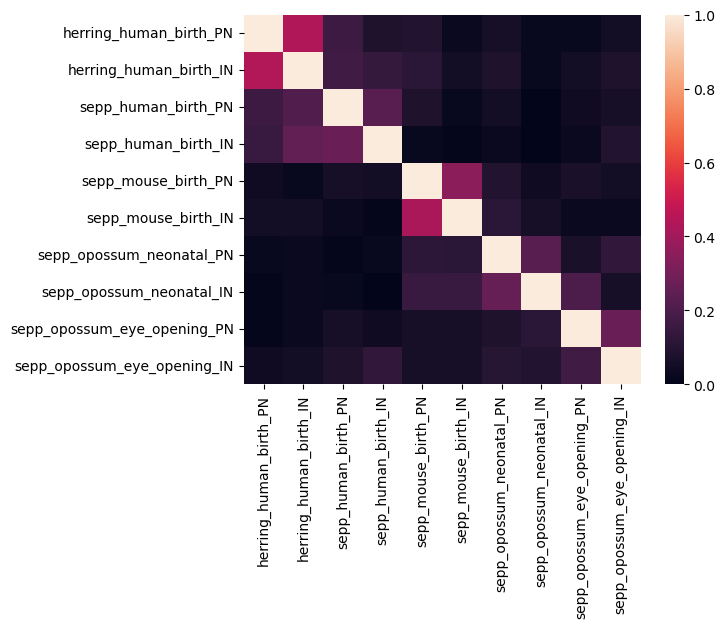

In [70]:
g = sns.heatmap(overlaps)

In [71]:
g.get_figure().savefig(str(FIG_PATH+'deg_overlaps.svg'), dpi=300, bbox_inches='tight')

Correlations are still quite low, less patterning seen. Try using only DEGs which are common to all datasets.

In [16]:
# Look for DEGs which are common to all datasets
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
herring = 'herring_human_birth'
herring_degs = list(dges['herring_human_birth']['PN']['up']['gene_symbol'].values.tolist() + dges['herring_human_birth']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['herring_human_birth']['PN']['down']['gene_symbol'].values.tolist() + dges['herring_human_birth']['IN']['down']['gene_symbol'].values.tolist())
herring_degs = pd.unique(herring_degs)
sepp_human_degs = list(dges['sepp_human_birth']['PN']['up']['gene_symbol'].values.tolist() + dges['sepp_human_birth']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['sepp_human_birth']['PN']['down']['gene_symbol'].values.tolist() + dges['sepp_human_birth']['IN']['down']['gene_symbol'].values.tolist())
sepp_human_degs = pd.unique(sepp_human_degs)
sepp_human_degs = [g for g in sepp_human_degs if g in herring_degs]
sepp_mouse_degs = list(dges['sepp_mouse_birth']['PN']['up']['gene_symbol'].values.tolist() + dges['sepp_mouse_birth']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['sepp_mouse_birth']['PN']['down']['gene_symbol'].values.tolist() + dges['sepp_mouse_birth']['IN']['down']['gene_symbol'].values.tolist())
sepp_mouse_degs = pd.unique(sepp_mouse_degs)
sepp_mouse_degs = [g for g in sepp_mouse_degs if g in sepp_human_degs]
sepp_opossum_degs = list(dges['sepp_opossum_neonatal']['PN']['up']['gene_symbol'].values.tolist() + dges['sepp_opossum_neonatal']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['sepp_opossum_neonatal']['PN']['down']['gene_symbol'].values.tolist() + dges['sepp_opossum_neonatal']['IN']['down']['gene_symbol'].values.tolist())
sepp_opossum_degs = pd.unique(sepp_opossum_degs)
sepp_opossum_degs = [g for g in sepp_opossum_degs if g in sepp_mouse_degs]
common_degs = list(dges['sepp_opossum_eye_opening']['PN']['up']['gene_symbol'].values.tolist() + dges['sepp_opossum_eye_opening']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['sepp_opossum_eye_opening']['PN']['down']['gene_symbol'].values.tolist() + dges['sepp_opossum_eye_opening']['IN']['down']['gene_symbol'].values.tolist())
common_degs = pd.unique(common_degs)
common_degs = [g for g in common_degs if g in sepp_mouse_degs]
len(common_degs)

/tmp/ipykernel_3688324/484390559.py:6: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  herring_degs = pd.unique(herring_degs)
/tmp/ipykernel_3688324/484390559.py:9: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  sepp_human_degs = pd.unique(sepp_human_degs)
/tmp/ipykernel_3688324/484390559.py:13: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  sepp_mouse_degs = pd.unique(sepp_mouse_degs)
/tmp/ipykernel_3688324/484390559.py:17: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  sepp_opossum_degs = pd.unique(sepp_opossum_degs)
/tmp/ipykernel_3688324/484390559.py:21: FutureWarning: uniqu

62

In [17]:
# Look for DEGs which are common to the human datasets plus the opossum at eye-opening
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
herring = 'herring_human_birth'
herring_degs = list(dges['herring_human_birth']['PN']['up']['gene_symbol'].values.tolist() + dges['herring_human_birth']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['herring_human_birth']['PN']['down']['gene_symbol'].values.tolist() + dges['herring_human_birth']['IN']['down']['gene_symbol'].values.tolist())
herring_degs = pd.unique(herring_degs)
sepp_human_degs = list(dges['sepp_human_birth']['PN']['up']['gene_symbol'].values.tolist() + dges['sepp_human_birth']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['sepp_human_birth']['PN']['down']['gene_symbol'].values.tolist() + dges['sepp_human_birth']['IN']['down']['gene_symbol'].values.tolist())
sepp_human_degs = pd.unique(sepp_human_degs)
sepp_human_degs = [g for g in sepp_human_degs if g in herring_degs]
common_degs = list(dges['sepp_opossum_eye_opening']['PN']['up']['gene_symbol'].values.tolist() + dges['sepp_opossum_eye_opening']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['sepp_opossum_eye_opening']['PN']['down']['gene_symbol'].values.tolist() + dges['sepp_opossum_eye_opening']['IN']['down']['gene_symbol'].values.tolist())
common_degs = pd.unique(common_degs)
common_degs = [g for g in common_degs if g in sepp_human_degs]
len(common_degs)

/tmp/ipykernel_3688324/1217057271.py:6: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  herring_degs = pd.unique(herring_degs)
/tmp/ipykernel_3688324/1217057271.py:9: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  sepp_human_degs = pd.unique(sepp_human_degs)
/tmp/ipykernel_3688324/1217057271.py:13: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_degs = pd.unique(common_degs)


220

In [18]:
# Look for DEGs which are common to the human datasets plus the rodents around birth
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
herring = 'herring_human_birth'
herring_degs = list(dges['herring_human_birth']['PN']['up']['gene_symbol'].values.tolist() + dges['herring_human_birth']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['herring_human_birth']['PN']['down']['gene_symbol'].values.tolist() + dges['herring_human_birth']['IN']['down']['gene_symbol'].values.tolist())
herring_degs = pd.unique(herring_degs)
sepp_human_degs = list(dges['sepp_human_birth']['PN']['up']['gene_symbol'].values.tolist() + dges['sepp_human_birth']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['sepp_human_birth']['PN']['down']['gene_symbol'].values.tolist() + dges['sepp_human_birth']['IN']['down']['gene_symbol'].values.tolist())
sepp_human_degs = pd.unique(sepp_human_degs)
sepp_human_degs = [g for g in sepp_human_degs if g in herring_degs]
sepp_mouse_degs = list(dges['sepp_mouse_birth']['PN']['up']['gene_symbol'].values.tolist() + dges['sepp_mouse_birth']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['sepp_mouse_birth']['PN']['down']['gene_symbol'].values.tolist() + dges['sepp_mouse_birth']['IN']['down']['gene_symbol'].values.tolist())
sepp_mouse_degs = pd.unique(sepp_mouse_degs)
sepp_mouse_degs = [g for g in sepp_mouse_degs if g in sepp_human_degs]
common_degs = list(dges['sepp_opossum_neonatal']['PN']['up']['gene_symbol'].values.tolist() + dges['sepp_opossum_neonatal']['IN']['up']['gene_symbol'].values.tolist() +
                    dges['sepp_opossum_neonatal']['PN']['down']['gene_symbol'].values.tolist() + dges['sepp_opossum_neonatal']['IN']['down']['gene_symbol'].values.tolist())
common_degs = pd.unique(sepp_opossum_degs)
common_degs = [g for g in common_degs if g in sepp_mouse_degs]
len(common_degs)

/tmp/ipykernel_3688324/1088276154.py:6: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  herring_degs = pd.unique(herring_degs)
/tmp/ipykernel_3688324/1088276154.py:9: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  sepp_human_degs = pd.unique(sepp_human_degs)
/tmp/ipykernel_3688324/1088276154.py:13: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  sepp_mouse_degs = pd.unique(sepp_mouse_degs)
/tmp/ipykernel_3688324/1088276154.py:17: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_degs = pd.unique(sepp_opossum_degs)


57

In [19]:
# Check expression for common DEGs
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_opossum_eye_opening']
summary = pd.DataFrame(index=common_degs)
for comp in comps:
    for c in ['PN', 'IN']:
        col = str(comp+'_'+c)
        data = pd.concat([dges[comp][c]['up'], dges[comp][c]['down']])
        expression = []
        for g in common_degs:
            if g not in data['gene_symbol'].values.tolist():
                expression.append(np.nan)
            else:
                expression.append(data.loc[data['gene_symbol'] == g]['log2FoldChange'].values[0])
        summary[col] = expression
summary

,herring_human_birth_PN,herring_human_birth_IN,sepp_human_birth_PN,sepp_human_birth_IN,sepp_opossum_eye_opening_PN,sepp_opossum_eye_opening_IN
NRXN3,2.865075,NaN,2.513726,NaN,1.519957,NaN
GRIN1,3.051485,2.819120,NaN,2.161064,1.009851,1.111076
SLC24A3,NaN,2.020825,NaN,1.895139,-2.672726,1.438965
CALB2,2.732302,NaN,4.242207,NaN,NaN,NaN
RGS7,NaN,1.766200,1.455438,NaN,1.428240,NaN
RYR2,1.578799,2.102632,2.838633,NaN,1.314591,1.619370
CEP112,1.446050,NaN,-1.437275,-1.558689,NaN,NaN
RBFOX3,1.735764,1.138980,NaN,1.587127,NaN,NaN
PTPRK,NaN,-1.541117,-2.165279,2.785726,-1.819392,1.971351
SYNE1,NaN,1.301329,3.043473,NaN,1.633397,NaN


In [17]:
# Function for searching specifically for sets of genes associated with certain GO terms for more of a supervised, targeted approach
# Takes as input search_terms, a list of strings containing terms that should be pulled out of the GMT files dges_search, a list of
#    DESeq2 differential gene expression outputs to match the searched genes to, species, a string which should be set to either
#    'human' or 'mouse' which determines which GMT file set to use, and dataset, indicating whether the data is from the Herring or Sepp set
# Returns the original list of outputs filtered to contain only the genes which were matched by the search with an adjusted
#    pvalue of <= 0.05 and absolute log2FoldChange of >= 1
def gene_search(search_terms, dges_search, species, dataset):
    # Read in GMT file
    import csv
    if species == 'human':
        go_file_bp = '/group/ll005/cmcphan/notebooks/analysis/c5.go.bp.v2024.1.Hs.symbols.gmt'
        go_file_mf = '/group/ll005/cmcphan/notebooks/analysis/c5.go.mf.v2024.1.Hs.symbols.gmt'
    elif species == 'mouse':
        go_file_bp = '/group/ll005/cmcphan/notebooks/analysis/m5.go.bp.v2024.1.Mm.symbols.gmt'
        go_file_mf = '/group/ll005/cmcphan/notebooks/analysis/m5.go.mf.v2024.1.Mm.symbols.gmt'
    else:
        raise ValueError("Species must be either 'human' or 'mouse'")
    GO_terms = {}
    with open( go_file_bp, 'r') as f:
        reader = csv.reader( f, delimiter='\t')
        for row in reader:
            GO_terms[row[1]] = np.array( row[2:])
    with open( go_file_mf, 'r') as f:
        reader = csv.reader( f, delimiter='\t')
        for row in reader:
            GO_terms[row[1]] = np.array( row[2:])

    keys = GO_terms.keys()
    # Check through keys in dictionary and record any that contain any of the substrings set in search_terms
    interesting_terms = [k for k in keys if any(t.upper() in k for t in search_terms)]
    
    interesting_genes = {} # Find gene sets we're interested in comparing
    for term in interesting_terms:
        key = term.split('/')[-1] # Get just the term rather than the whole URL for easier reading
        interesting_genes[key] = GO_terms[term]
    
    interesting_genes_list = []
    for gene_set in interesting_genes:
        interesting_genes_list.extend(interesting_genes[gene_set])
    interesting_genes_list = np.unique(interesting_genes_list).tolist()
    interesting_genes_list = [g.upper() for g in interesting_genes_list]
 
    search_results = {}
    for dge, c in zip(dges_search, ['PN', 'IN']):
        # Add capitalized gene symbols to new column for comparisons
        if dataset == 'sepp':
            dge['gene_symbol'] = [sepp_id_to_symbol[g].upper() if sepp_id_to_symbol[g] is not None else g for g in dge.index.tolist()] 
        elif dataset == 'herring':
            dge['gene_symbol'] = [g.upper() for g in dge.index.tolist()]
        search_genes = []
        degs = dge.sort_values(by='pvalue').dropna().query('padj <= 0.05').query('log2FoldChange >= 1 | log2FoldChange <= -1')
        degs = degs.loc[degs['gene_symbol'].isin(common_genes)] # Limit to only common genes
        degs_list = degs['gene_symbol'].values.tolist()
        degs_search_related = []
        filtered_genes = [g.upper() for g in interesting_genes_list if g in degs_list]
        if len(filtered_genes) > 0:
            degs_search_related.extend(filtered_genes)
        search_genes = np.unique(degs_search_related).tolist()
        degs_up = dge.loc[dge['gene_symbol'].isin(search_genes)].query('log2FoldChange > 0')
        degs_down = dge.loc[dge['gene_symbol'].isin(search_genes)].query('log2FoldChange < 0')
        search_results[c] = {'up': degs_up, 'down': degs_down}
    return search_results

In [18]:
search_results = {}
search_terms = ['HISTONE', 'METHYLATION', 'METHYLTRANSFERASE', 'ACETYLATION', 'ACETYLTRANSFERASE', 'EPIGENETIC']
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/herring_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/sepp_human_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/sepp_mouse_fetal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_neonatal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_adolescence_infancy_']
species = ['human', 'human', 'mouse', 'human', 'human']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp']
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
for p, s, d, c in zip(paths, species, datasets, comps):
    dges_search = []
    dges_search.append(pd.read_csv(str(p+'PN'), index_col=0))
    dges_search.append(pd.read_csv(str(p+'IN'), index_col=0))
    epigenetic = gene_search(search_terms, dges_search, s, d)
    search_results[c] = epigenetic
search_results

{'herring_human_birth': {'PN': {'up':              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
   MEF2D     1808.588355        1.528004  0.547030  2.793271  5.217802e-03   
   APLF       768.998298        2.860305  0.461771  6.194214  5.857678e-10   
   ZCWPW2    1229.315110        1.169271  0.418954  2.790929  5.255698e-03   
   NAT8L     1379.692956        2.575844  0.591393  4.355551  1.327324e-05   
   TPPP      1000.010186        2.300841  0.706065  3.258680  1.119319e-03   
   PRDM6       81.554625        1.951256  0.562812  3.466978  5.263450e-04   
   JADE2      636.514744        2.043415  0.707360  2.888791  3.867256e-03   
   EGR1      1708.203647        6.359344  0.950844  6.688103  2.260825e-11   
   SCML4      219.006194        1.444393  0.506166  2.853593  4.322789e-03   
   NACC2      128.246288        2.565545  0.559011  4.589437  4.444426e-06   
   SFMBT2    6694.311189        1.421827  0.515704  2.757061  5.832352e-03   
   PRMT8     4596.531945     

In [90]:
# Collate results into a single CSV
up = None
down = None
for comp in search_results:
    for c in ['PN', 'IN']:
        for d in ['up', 'down']:
            search_results[comp][c][d].insert(0, 'dataset', comp)
    up = pd.concat([up, search_results[comp]['PN']['up'], search_results[comp]['IN']['up']])
    down = pd.concat([down, search_results[comp]['PN']['down'], search_results[comp]['IN']['down']])
summary = None
path = '/group/ll005/cmcphan/notebooks/analysis/results/epigenetic/'
data = up
data.insert(1, 'direction_of_change', 'up')
summary = pd.concat([summary, data])
data = down
data.insert(1, 'direction_of_change', 'down')
summary = pd.concat([summary, data])
summary.to_csv(str(path+'epigenetic_search_results_summary.csv'))
summary

,dataset,direction_of_change,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol
MEF2D,herring_human_birth,up,1808.588355,1.528004,0.547030,2.793271,5.217802e-03,3.943803e-02,MEF2D
APLF,herring_human_birth,up,768.998298,2.860305,0.461771,6.194214,5.857678e-10,6.061875e-08,APLF
ZCWPW2,herring_human_birth,up,1229.315110,1.169271,0.418954,2.790929,5.255698e-03,3.960509e-02,ZCWPW2
NAT8L,herring_human_birth,up,1379.692956,2.575844,0.591393,4.355551,1.327324e-05,3.624528e-04,NAT8L
TPPP,herring_human_birth,up,1000.010186,2.300841,0.706065,3.258680,1.119319e-03,1.245025e-02,TPPP
...,...,...,...,...,...,...,...,...,...
ENSMODG00000016677,sepp_opossum_eye_opening,down,830.311047,-2.548939,0.434335,-5.868607,4.394720e-09,7.320093e-07,SFMBT2
ENSMODG00000013826,sepp_opossum_eye_opening,down,666.160280,-1.040517,0.334462,-3.111018,1.864437e-03,3.663362e-02,TRIM24
ENSMODG00000015823,sepp_opossum_eye_opening,down,99.289671,-1.727271,0.571943,-3.020008,2.527678e-03,4.620999e-02,KANSL1L
ENSMODG00000008148,sepp_opossum_eye_opening,down,24.769139,-3.754316,1.215380,-3.089006,2.008273e-03,3.877801e-02,DACT1


In [91]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = search_results['herring_human_birth'][cell_type]['up']['gene_symbol'].values.tolist()
    down = search_results['herring_human_birth'][cell_type]['down']['gene_symbol'].values.tolist()
    for comp in ['sepp_human_birth']:
        up = [g for g in up if g in search_results[comp][cell_type]['up']['gene_symbol'].values.tolist()]
        down = [g for g in down if g in search_results[comp][cell_type]['down']['gene_symbol'].values.tolist()]
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = [g for g in up if g not in down]
    down = [g for g in down if g not in up]
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [92]:
common_up

{'PN': ['MEF2D', 'CDYL2', 'ZBTB7A'], 'IN': ['NAT8L', 'BHLHE41']}

In [93]:
common_down

{'PN': ['KDM1A', 'LMNA', 'SOX4', 'HDAC2', 'ACAT2', 'CBX3', 'PHF6', 'MYC'],
 'IN': ['KDM5B', 'SOX4', 'SAT2', 'DNMT3B']}

UP\
See below for BHLHE41. [NAT8L](https://www.genecards.org/cgi-bin/carddisp.pl?gene=NAT8L#function) involved in the synthesis of N-acetylaspartate acid, a [prominent CNS metabolite](https://pmc.ncbi.nlm.nih.gov/articles/PMC1919520/#S45) implicated in a wide range of neurological disorders.\
\
[MEF2D](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MEF2D#function) is a transcriptional activator which mediates neuronal differentiation and survival, with a crucial role in regulation of apoptosis in neurons.\
[CDYL2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MEF2D#function) not much on this one, implicated as a transcriptional corepressor involved in negatively regulating transcription.\
[ZBTB7A](https://www.genecards.org/cgi-bin/carddisp.pl?gene=Zbtb7a) is a transcriptional repressor of genes involved in cell differentiation and proliferation\
\
DOWN\
[SOX4](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SOX4) is a transcriptional activator which regulates embryonic development and cell fate\
[KDM1A](https://www.genecards.org/cgi-bin/carddisp.pl?gene=KDM1A) and [KDM5B](https://www.genecards.org/cgi-bin/carddisp.pl?gene=KDM5B) are histone demethylases (repressors) which seem to be quite important epigenetic regulators see [here](https://www.nature.com/articles/s41467-024-45773-3#Sec11) and [here](https://pmc.ncbi.nlm.nih.gov/articles/PMC6522339/)

In [52]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = search_results['sepp_human_birth'][cell_type]['up']['gene_symbol'].values.tolist()
    down = search_results['sepp_human_birth'][cell_type]['down']['gene_symbol'].values.tolist()
    for comp in ['sepp_opossum_neonatal']:
        up = [g for g in up if g in search_results[comp][cell_type]['up']['gene_symbol'].values.tolist()]
        down = [g for g in down if g in search_results[comp][cell_type]['down']['gene_symbol'].values.tolist()]
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = [g for g in up if g not in down]
    down = [g for g in down if g not in up]
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [53]:
common_up

{'PN': [], 'IN': ['NAT8L', 'TRIM37', 'BHLHE41']}

In [54]:
common_down

{'PN': [], 'IN': []}

None present across all species at birth, limited overlap between human and opossum in NAT8L, TRIM37 and BHLHE41 upregulated in INs, but no overlap at all with mouse.

In [25]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = search_results['herring_human_birth'][cell_type]['up']['gene_symbol'].values.tolist()
    down = search_results['herring_human_birth'][cell_type]['down']['gene_symbol'].values.tolist()
    for comp in ['sepp_human_birth', 'sepp_opossum_eye_opening']:
        up = [g for g in up if g in search_results[comp][cell_type]['up']['gene_symbol'].values.tolist()]
        down = [g for g in down if g in search_results[comp][cell_type]['down']['gene_symbol'].values.tolist()]
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = [g for g in up if g not in down]
    down = [g for g in down if g not in up]
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [26]:
common_up

{'PN': [], 'IN': ['BHLHE41']}

In [27]:
common_down

{'PN': ['SOX4'], 'IN': []}

[BHLHE41](https://www.genecards.org/cgi-bin/carddisp.pl?gene=BHLHE41). Noted function as transcriptional repressor thought to be involved in the control of circadian rhythm and cell differentiation. Commonly upregulated, consistent with a switch away from cell differentiation during this period.\
See above for SOX4

In [66]:
search_results = {}
search_terms = ['OXYGEN_LEVELS', 'REACTIVE_OXYGEN_SPECIES', 'OXYGEN_RADICAL', 'OXYGEN_HOMEOSTASIS']
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/herring_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/sepp_human_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/sepp_mouse_fetal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_neonatal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_adolescence_infancy_']
species = ['human', 'human', 'mouse', 'human', 'human']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp']
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
for p, s, d, c in zip(paths, species, datasets, comps):
    dges_search = []
    dges_search.append(pd.read_csv(str(p+'PN'), index_col=0))
    dges_search.append(pd.read_csv(str(p+'IN'), index_col=0))
    res = gene_search(search_terms, dges_search, s, d)
    search_results[c] = res
search_results

{'herring_human_birth': {'PN': {'up':               baseMean  log2FoldChange     lfcSE      stat        pvalue  \
   OPRD1       322.046882        3.794368  0.514571  7.373852  1.657678e-13   
   GPR37L1     181.242311        4.020468  1.033883  3.888709  1.007788e-04   
   ADORA1      805.576779        1.674370  0.623402  2.685859  7.234363e-03   
   AGT         139.979149        3.708954  1.126368  3.292844  9.917954e-04   
   RYR2      36400.275394        1.578799  0.564507  2.796773  5.161578e-03   
   KCNK3       642.297044        2.032073  0.625992  3.246166  1.169705e-03   
   EPHA4     11178.054331        1.631016  0.490254  3.326877  8.782516e-04   
   ATG7       4622.059732        2.269117  0.608723  3.727666  1.932610e-04   
   PPARG      1463.522993        2.446413  0.481051  5.085556  3.665504e-07   
   PRKCD       184.165211        1.747760  0.614304  2.845105  4.439674e-03   
   FAM162A     609.270578        1.673551  0.516779  3.238426  1.201910e-03   
   EGR1       170

In [101]:
# Collate results into a single CSV
up = None
down = None
for comp in search_results:
    for c in ['PN', 'IN']:
        for d in ['up', 'down']:
            search_results[comp][c][d].insert(0, 'dataset', comp)
    up = pd.concat([up, search_results[comp]['PN']['up'], search_results[comp]['IN']['up']])
    down = pd.concat([down, search_results[comp]['PN']['down'], search_results[comp]['IN']['down']])
summary = None
path = '/group/ll005/cmcphan/notebooks/analysis/results/oxygenation/'
data = up
data.insert(1, 'direction_of_change', 'up')
summary = pd.concat([summary, data])
data = down
data.insert(1, 'direction_of_change', 'down')
summary = pd.concat([summary, data])
summary.to_csv(str(path+'oxygenation_search_results_summary.csv'))
summary

,dataset,direction_of_change,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol
OPRD1,herring_human_birth,up,322.046882,3.794368,0.514571,7.373852,1.657678e-13,4.034169e-11,OPRD1
GPR37L1,herring_human_birth,up,181.242311,4.020468,1.033883,3.888709,1.007788e-04,1.899345e-03,GPR37L1
ADORA1,herring_human_birth,up,805.576779,1.674370,0.623402,2.685859,7.234363e-03,4.977080e-02,ADORA1
AGT,herring_human_birth,up,139.979149,3.708954,1.126368,3.292844,9.917954e-04,1.135693e-02,AGT
RYR2,herring_human_birth,up,36400.275394,1.578799,0.564507,2.796773,5.161578e-03,3.914558e-02,RYR2
...,...,...,...,...,...,...,...,...,...
ENSMODG00000014304,sepp_opossum_eye_opening,down,80.293483,-2.918239,0.660145,-4.420604,9.842536e-06,5.945180e-04,PXDN
ENSMODG00000003112,sepp_opossum_eye_opening,down,51.796883,-2.778987,0.898298,-3.093613,1.977355e-03,3.822577e-02,ZEB2
ENSMODG00000014724,sepp_opossum_eye_opening,down,831.434901,-2.080663,0.356752,-5.832243,5.468730e-09,8.967570e-07,GUCY1A2
ENSMODG00000000163,sepp_opossum_eye_opening,down,690.667992,-1.103670,0.361060,-3.056752,2.237491e-03,4.202303e-02,SESN3


In [102]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = search_results['herring_human_birth'][cell_type]['up']['gene_symbol'].values.tolist()
    down = search_results['herring_human_birth'][cell_type]['down']['gene_symbol'].values.tolist()
    for comp in ['sepp_human_birth']:
        up = [g for g in up if g in search_results[comp][cell_type]['up']['gene_symbol'].values.tolist()]
        down = [g for g in down if g in search_results[comp][cell_type]['down']['gene_symbol'].values.tolist()]
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = [g for g in up if g not in down]
    down = [g for g in down if g not in up]
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [103]:
common_up

{'PN': ['AGT', 'RYR2', 'PPARG', 'PPARGC1B'],
 'IN': ['MAP3K5', 'GRIN1', 'SLC8A3', 'CYGB', 'RYR1']}

In [104]:
common_down

{'PN': ['LMNA', 'SOX4', 'HDAC2', 'MYC'], 'IN': ['PXDN', 'SOX4', 'ANGPT2']}

In [67]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = search_results['sepp_human_birth'][cell_type]['up']['gene_symbol'].values.tolist()
    down = search_results['sepp_human_birth'][cell_type]['down']['gene_symbol'].values.tolist()
    for comp in ['sepp_mouse_birth', 'sepp_opossum_neonatal']:
        up = [g for g in up if g in search_results[comp][cell_type]['up']['gene_symbol'].values.tolist()]
        down = [g for g in down if g in search_results[comp][cell_type]['down']['gene_symbol'].values.tolist()]
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = [g for g in up if g not in down]
    down = [g for g in down if g not in up]
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [68]:
common_up

{'PN': ['RYR2'], 'IN': ['PTPRK', 'GRIN1']}

In [69]:
common_down

{'PN': [], 'IN': []}

A couple of hits across all 3 species at birth. [RYR2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=RYR2) is a receptor in cardiac muscle sarcoplasmic reticulum for a calcium gated channel implicated in cardiac muscle contraction.\
[GRIN1](https://www.genecards.org/cgi-bin/carddisp.pl?gene=GRIN1) is a subunit for a family of glutamate receptor channels involved in synaptic plasticity, linked to learning and memory

In [108]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = search_results['herring_human_birth'][cell_type]['up']['gene_symbol'].values.tolist()
    down = search_results['herring_human_birth'][cell_type]['down']['gene_symbol'].values.tolist()
    for comp in ['sepp_human_birth', 'sepp_opossum_eye_opening']:
        up = [g for g in up if g in search_results[comp][cell_type]['up']['gene_symbol'].values.tolist()]
        down = [g for g in down if g in search_results[comp][cell_type]['down']['gene_symbol'].values.tolist()]
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = [g for g in up if g not in down]
    down = [g for g in down if g not in up]
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [109]:
common_up

{'PN': ['RYR2', 'PPARGC1B'], 'IN': ['MAP3K5', 'GRIN1', 'SLC8A3']}

In [110]:
common_down

{'PN': ['SOX4'], 'IN': ['PXDN']}

More common genes across human birth and opossum eye-opening may just be because we're comparing across fewer species and therefore getting more hits, but if this pattern is borne out for the mouse at eye-opening in the agewise comparisons as well then it could be more evidence to point towards the changes at eye-opening being more similar to those at birth in humans.\
\
[PPARGC1B](https://www.genecards.org/cgi-bin/carddisp.pl?gene=PPARGC1B) is a transcription factor stimulator associated with regulation of fat oxidation, non-oxidative glucose metabolism and energy expenditure\
[MAP3K5](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MAP3K5) is a serine/threonine kinase which is part of the MAP kinase signalling cascade, important in cellular responses to changes in environment and mediates signal transduction for stressors **such as oxidative stress**\
[SLC8A3](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SLC8A3) is a membrane protein which acts in calcium exchange - in neurons this functions to return Ca2+ levels back to baseline after neuronal activation and is therefore involved in synaptic plasticity, learning and memory\
[PXDN](https://www.genecards.org/cgi-bin/carddisp.pl?gene=PXDN) forms part of the extra-cellular matrix and is required for proper signalling\
\
Check to see if MAP3K5 is also differentially expressed in the opossum close to birth

In [111]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = search_results['herring_human_birth'][cell_type]['up']['gene_symbol'].values.tolist()
    down = search_results['herring_human_birth'][cell_type]['down']['gene_symbol'].values.tolist()
    for comp in ['sepp_human_birth', 'sepp_opossum_neonatal']:
        up = [g for g in up if g in search_results[comp][cell_type]['up']['gene_symbol'].values.tolist()]
        down = [g for g in down if g in search_results[comp][cell_type]['down']['gene_symbol'].values.tolist()]
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = [g for g in up if g not in down]
    down = [g for g in down if g not in up]
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [112]:
common_up

{'PN': ['RYR2'], 'IN': ['MAP3K5', 'GRIN1']}

Yes, so this suggests that the changes due to oxidative stress happened already at birth and are carried through to eye opening, rather than actually happening at eye-opening

In [62]:
search_results = {}
search_terms = ['TRANSCRIPTION_FACTOR']
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/herring_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/sepp_human_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/sepp_mouse_fetal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_neonatal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_adolescence_infancy_']
species = ['human', 'human', 'mouse', 'human', 'human']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp']
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
for p, s, d, c in zip(paths, species, datasets, comps):
    dges_search = []
    dges_search.append(pd.read_csv(str(p+'PN'), index_col=0))
    dges_search.append(pd.read_csv(str(p+'IN'), index_col=0))
    res = gene_search(search_terms, dges_search, s, d)
    search_results[c] = res
search_results

{'herring_human_birth': {'PN': {'up':             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
   OPRD1     322.046882        3.794368  0.514571  7.373852  1.657678e-13   
   HIVEP3  23008.704150        1.309120  0.396344  3.302987  9.566097e-04   
   NOTCH2    799.669905        1.927393  0.550978  3.498128  4.685369e-04   
   MEF2D    1808.588355        1.528004  0.547030  2.793271  5.217802e-03   
   PRRX1     180.542782        3.192612  0.839497  3.803004  1.429520e-04   
   ...              ...             ...       ...       ...           ...   
   ZBTB46   2413.228220        1.435767  0.503180  2.853385  4.325620e-03   
   ZBTB7A   2257.409355        2.745136  0.545270  5.034457  4.792050e-07   
   NWD1      546.668533        2.677545  0.799689  3.348232  8.132888e-04   
   CRTC1    3397.156027        1.643301  0.580855  2.829107  4.667811e-03   
   TEF       740.504719        2.324110  0.496742  4.678710  2.886849e-06   
   
                   padj gene_symbol  

In [114]:
# Collate results into a single CSV
up = None
down = None
for comp in search_results:
    for c in ['PN', 'IN']:
        for d in ['up', 'down']:
            search_results[comp][c][d].insert(0, 'dataset', comp)
    up = pd.concat([up, search_results[comp]['PN']['up'], search_results[comp]['IN']['up']])
    down = pd.concat([down, search_results[comp]['PN']['down'], search_results[comp]['IN']['down']])
summary = None
path = '/group/ll005/cmcphan/notebooks/analysis/results/transcription_factors/'
data = up
data.insert(1, 'direction_of_change', 'up')
summary = pd.concat([summary, data])
data = down
data.insert(1, 'direction_of_change', 'down')
summary = pd.concat([summary, data])
summary.to_csv(str(path+'transcription_factor_search_results_summary.csv'))
summary

,dataset,direction_of_change,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol
OPRD1,herring_human_birth,up,322.046882,3.794368,0.514571,7.373852,1.657678e-13,4.034169e-11,OPRD1
HIVEP3,herring_human_birth,up,23008.704150,1.309120,0.396344,3.302987,9.566097e-04,1.103964e-02,HIVEP3
NOTCH2,herring_human_birth,up,799.669905,1.927393,0.550978,3.498128,4.685369e-04,6.390059e-03,NOTCH2
MEF2D,herring_human_birth,up,1808.588355,1.528004,0.547030,2.793271,5.217802e-03,3.943803e-02,MEF2D
PRRX1,herring_human_birth,up,180.542782,3.192612,0.839497,3.803004,1.429520e-04,2.498671e-03,PRRX1
...,...,...,...,...,...,...,...,...,...
ENSMODG00000006145,sepp_opossum_eye_opening,down,196.001544,-1.869819,0.461084,-4.055266,5.007737e-05,2.231827e-03,VGLL4
ENSMODG00000015982,sepp_opossum_eye_opening,down,406.501062,-1.501982,0.385888,-3.892273,9.930954e-05,3.755996e-03,KLF7
ENSMODG00000021190,sepp_opossum_eye_opening,down,240.853482,-4.050293,0.671046,-6.035795,1.581824e-09,2.930818e-07,PAX3
ENSMODG00000008148,sepp_opossum_eye_opening,down,24.769139,-3.754316,1.215380,-3.089006,2.008273e-03,3.877801e-02,DACT1


In [115]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = search_results['herring_human_birth'][cell_type]['up']['gene_symbol'].values.tolist()
    down = search_results['herring_human_birth'][cell_type]['down']['gene_symbol'].values.tolist()
    for comp in ['sepp_human_birth']:
        up = [g for g in up if g in search_results[comp][cell_type]['up']['gene_symbol'].values.tolist()]
        down = [g for g in down if g in search_results[comp][cell_type]['down']['gene_symbol'].values.tolist()]
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = [g for g in up if g not in down]
    down = [g for g in down if g not in up]
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [116]:
common_up

{'PN': ['MEF2D',
  'AGT',
  'KCNIP3',
  'PPARG',
  'MED12L',
  'SMAD1',
  'NR3C1',
  'PPARGC1B',
  'ZBTB7A',
  'TEF'],
 'IN': ['ESRRG',
  'NPAS2',
  'NR1D2',
  'WFS1',
  'KIT',
  'PURA',
  'NR3C1',
  'ENPP1',
  'KLF9',
  'BHLHE41']}

In [117]:
common_down

{'PN': ['KDM1A',
  'TCF7',
  'SOX4',
  'HDAC2',
  'CBX3',
  'NEUROD6',
  'MYC',
  'MEIS2',
  'MAFB'],
 'IN': ['KLF7', 'EPHA5', 'ELF2', 'ID4', 'SOX4', 'FOXP2', 'E2F5', 'PBX3']}

In [63]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = search_results['sepp_human_birth'][cell_type]['up']['gene_symbol'].values.tolist()
    down = search_results['sepp_human_birth'][cell_type]['down']['gene_symbol'].values.tolist()
    for comp in ['sepp_mouse_birth', 'sepp_opossum_neonatal']:
        up = [g for g in up if g in search_results[comp][cell_type]['up']['gene_symbol'].values.tolist()]
        down = [g for g in down if g in search_results[comp][cell_type]['down']['gene_symbol'].values.tolist()]
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = [g for g in up if g not in down]
    down = [g for g in down if g not in up]
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [64]:
common_up

{'PN': [], 'IN': ['ADCY8']}

In [65]:
common_down

{'PN': ['MEIS2'], 'IN': ['RFX4']}

Only one TF gene common to all species and both tissues\
[MEIS2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MEIS2) is a highly conserved transcriptional regulator, no listed functions specific to CNS/neurons

In [121]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = search_results['herring_human_birth'][cell_type]['up']['gene_symbol'].values.tolist()
    down = search_results['herring_human_birth'][cell_type]['down']['gene_symbol'].values.tolist()
    for comp in ['sepp_human_birth', 'sepp_opossum_eye_opening']:
        up = [g for g in up if g in search_results[comp][cell_type]['up']['gene_symbol'].values.tolist()]
        down = [g for g in down if g in search_results[comp][cell_type]['down']['gene_symbol'].values.tolist()]
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = [g for g in up if g not in down]
    down = [g for g in down if g not in up]
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [122]:
common_up

{'PN': ['NR3C1', 'PPARGC1B', 'TEF'],
 'IN': ['NPAS2', 'NR1D2', 'ENPP1', 'KLF9', 'BHLHE41']}

In [123]:
common_down

{'PN': ['TCF7', 'SOX4', 'MEIS2'], 'IN': ['KLF7', 'EPHA5', 'FOXP2']}

PPARGC1B and BHLHE41 are listed above

---

### Agewise Comparisons

In [124]:
dges = {}
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp', 'sepp']
comps = ['herring_86d_ga24', 'sepp_human_5d_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P5_EO14', 'sepp_opossum_P60_P21']
for p, d, c in zip(paths, datasets, comps):
    comp_dges = {}
    dge = pd.read_csv(str(p+c), index_col=0)
    if d == 'sepp':
        dge['gene_symbol'] = [sepp_id_to_symbol[g].upper() if sepp_id_to_symbol[g] is not None else g for g in dge.index.tolist()]
    elif d == 'herring':
        dge['gene_symbol'] = [g.upper() for g in dge.index.to_list()]
    dge = dge.query('padj <= 0.05')
    dge_up = dge.query('log2FoldChange >= 3')
    dge_down = dge.query('log2FoldChange <= -3')
    comp_dges = {'up': dge_up, 'down': dge_down}
    dges[c] = comp_dges
dges

{'herring_86d_ga24': {'up':                   baseMean  log2FoldChange     lfcSE       stat        pvalue  \
  GABRD            22.894962        4.604421  0.393703  11.695164  1.349263e-31   
  GLIS1             9.872937        3.315116  0.392573   8.444578  3.051470e-17   
  AK5             105.388635        3.055005  0.373340   8.182900  2.770942e-16   
  RGS4             11.438680        3.907333  0.514142   7.599719  2.967735e-14   
  SLC30A3          17.035172        3.960174  0.752979   5.259339  1.445744e-07   
  ALS2CR12         12.294365        4.196420  0.377281  11.122812  9.716080e-29   
  CCK              94.673913        3.239790  0.387351   8.363964  6.064533e-17   
  RP11-33A14.1     17.946228        3.245933  0.565011   5.744907  9.197170e-09   
  SST              50.525364        3.003293  0.481441   6.238130  4.428328e-10   
  NAT8L            64.529520        3.370166  0.388115   8.683412  3.840684e-18   
  SPARCL1         127.950403        3.271056  0.450121   7.26

In [125]:
# Look at similarity in significant DEGs with a strong log fold change across comparisons
df_matrix = []
index = []
for y in range(0, len(comps)): # Each row gets made one by one, so the first index here is actually the y axis
    comp_y = comps[y]
    props = []
    index.append(str(comp_y))
    for x in range(0, len(comps)):
        comp_x = comps[x]
        if x == y:
            props.append(1) # Perfect overlap with self
        elif x > y: # Top half is upregulated results
                genes_x = dges[comp_x]['up']['gene_symbol'].values
                genes_y = dges[comp_y]['up']['gene_symbol'].values
                overlap = [g for g in genes_x if g in genes_y]
                try:
                    props.append(len(overlap)/len(genes_x))
                except ZeroDivisionError:
                    props.append(0)
        elif x < y: # Bottom half is downregulated results
            genes_x = dges[comp_x]['down']['gene_symbol'].values
            genes_y = dges[comp_y]['down']['gene_symbol'].values
            overlap = [g for g in genes_x if g in genes_y]
            try:
                props.append(len(overlap)/len(genes_x))
            except ZeroDivisionError:
                props.append(0)
    df_matrix.append(props)
overlaps = pd.DataFrame(df_matrix, index=index, columns=index)
overlaps

,herring_86d_ga24,sepp_human_5d_20wpc,sepp_mouse_P4_EM13.5,sepp_mouse_9w_P7,sepp_opossum_P5_EO14,sepp_opossum_P60_P21
herring_86d_ga24,1.000000,0.002320,0.005682,0.010000,0.016129,0.012195
sepp_human_5d_20wpc,0.014260,1.000000,0.011364,0.005000,0.000000,0.012195
sepp_mouse_P4_EM13.5,0.005348,0.019608,1.000000,0.030000,0.064516,0.024390
sepp_mouse_9w_P7,0.014260,0.015686,0.032258,1.000000,0.032258,0.024390
sepp_opossum_P5_EO14,0.000000,0.000000,0.000000,0.001642,1.000000,0.000000
sepp_opossum_P60_P21,0.005348,0.015686,0.024194,0.021346,0.222222,1.000000


<Axes: >

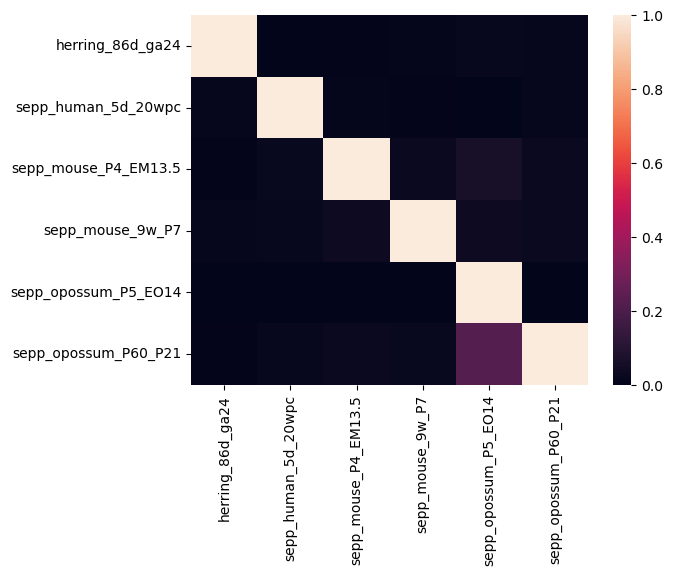

In [126]:
sns.heatmap(overlaps)

In [127]:
# Use genes common to all datasets
dges = {}
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp', 'sepp']
comps = ['herring_86d_ga24', 'sepp_human_5d_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P5_EO14', 'sepp_opossum_P60_P21']
for p, d, c in zip(paths, datasets, comps):
    comp_dges = {}
    dge = pd.read_csv(str(p+c), index_col=0)
    if d == 'sepp':
        dge['gene_symbol'] = [sepp_id_to_symbol[g].upper() if sepp_id_to_symbol[g] is not None else g for g in dge.index.tolist()]
    elif d == 'herring':
        dge['gene_symbol'] = [g.upper() for g in dge.index.to_list()]
    dge = dge.loc[dge['gene_symbol'].isin(common_genes)] # Limit to only genes common to all datasets
    dge = dge.query('padj <= 0.05')
    dge_up = dge.query('log2FoldChange >= 3')
    dge_down = dge.query('log2FoldChange <= -3')
    comp_dges = {'up': dge_up, 'down': dge_down}
    dges[c] = comp_dges
dges

{'herring_86d_ga24': {'up':              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
  RGS4        11.438680        3.907333  0.514142   7.599719  2.967735e-14   
  CCK         94.673913        3.239790  0.387351   8.363964  6.064533e-17   
  SST         50.525364        3.003293  0.481441   6.238130  4.428328e-10   
  NAT8L       64.529520        3.370166  0.388115   8.683412  3.840684e-18   
  CDH9       200.967820        3.138627  0.334400   9.385847  6.241261e-21   
  CXCL14      70.501778        4.072838  0.463396   8.789108  1.507526e-18   
  NME5        24.019407        3.269626  0.407855   8.016642  1.086753e-15   
  SGCD       494.374191        3.201142  0.511046   6.263906  3.754509e-10   
  MLIP        48.146600        3.033876  0.550747   5.508652  3.615927e-08   
  MMD2       141.357231        3.085479  0.394729   7.816704  5.422442e-15   
  CADPS2      68.523480        3.338518  0.555319   6.011888  1.833754e-09   
  LYNX1       12.404458        3.11027

In [128]:
# Look at similarity in significant DEGs with a strong log fold change across comparisons
df_matrix = []
index = []
for y in range(0, len(comps)): # Each row gets made one by one, so the first index here is actually the y axis
    comp_y = comps[y]
    props = []
    index.append(str(comp_y))
    for x in range(0, len(comps)):
        comp_x = comps[x]
        if x == y:
            props.append(1) # Perfect overlap with self
        elif x > y: # Top half is upregulated results
                genes_x = dges[comp_x]['up']['gene_symbol'].values
                genes_y = dges[comp_y]['up']['gene_symbol'].values
                overlap = [g for g in genes_x if g in genes_y]
                try:
                    props.append(len(overlap)/len(genes_x))
                except ZeroDivisionError:
                    props.append(0)
        elif x < y: # Bottom half is downregulated results
            genes_x = dges[comp_x]['down']['gene_symbol'].values
            genes_y = dges[comp_y]['down']['gene_symbol'].values
            overlap = [g for g in genes_x if g in genes_y]
            try:
                props.append(len(overlap)/len(genes_x))
            except ZeroDivisionError:
                props.append(0)
    df_matrix.append(props)
overlaps = pd.DataFrame(df_matrix, index=index, columns=index)
overlaps

,herring_86d_ga24,sepp_human_5d_20wpc,sepp_mouse_P4_EM13.5,sepp_mouse_9w_P7,sepp_opossum_P5_EO14,sepp_opossum_P60_P21
herring_86d_ga24,1.00,0.029412,0.025806,0.011236,0.037037,0.0625
sepp_human_5d_20wpc,0.04,1.000000,0.012903,0.000000,0.000000,0.0625
sepp_mouse_P4_EM13.5,0.02,0.047619,1.000000,0.044944,0.148148,0.1250
sepp_mouse_9w_P7,0.08,0.031746,0.025000,1.000000,0.074074,0.1250
sepp_opossum_P5_EO14,0.00,0.000000,0.000000,0.005464,1.000000,0.0000
sepp_opossum_P60_P21,0.06,0.063492,0.075000,0.065574,0.000000,1.0000


<Axes: >

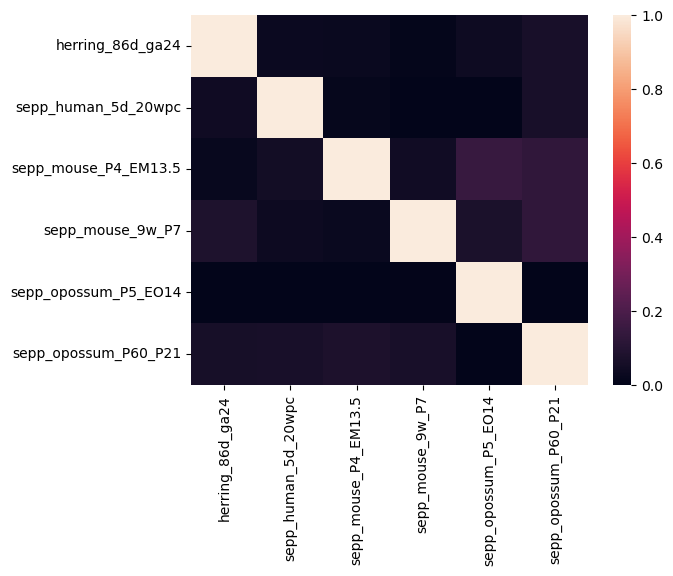

In [129]:
sns.heatmap(overlaps)

In [130]:
# Loosen log fold cutoff
# Use genes common to all datasets
dges = {}
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp', 'sepp']
comps = ['herring_86d_ga24', 'sepp_human_5d_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P5_EO14', 'sepp_opossum_P60_P21']
for p, d, c in zip(paths, datasets, comps):
    comp_dges = {}
    dge = pd.read_csv(str(p+c), index_col=0)
    if d == 'sepp':
        dge['gene_symbol'] = [sepp_id_to_symbol[g].upper() if sepp_id_to_symbol[g] is not None else g for g in dge.index.tolist()]
    elif d == 'herring':
        dge['gene_symbol'] = [g.upper() for g in dge.index.to_list()]
    dge = dge.loc[dge['gene_symbol'].isin(common_genes)] # Limit to only genes common to all datasets
    dge = dge.query('padj <= 0.05')
    dge_up = dge.query('log2FoldChange >= 1')
    dge_down = dge.query('log2FoldChange <= -1')
    comp_dges = {'up': dge_up, 'down': dge_down}
    dges[c] = comp_dges

In [131]:
# Look at similarity in significant DEGs with a strong log fold change across comparisons
df_matrix = []
index = []
for y in range(0, len(comps)): # Each row gets made one by one, so the first index here is actually the y axis
    comp_y = comps[y]
    props = []
    index.append(str(comp_y))
    for x in range(0, len(comps)):
        comp_x = comps[x]
        if x == y:
            props.append(1) # Perfect overlap with self
        elif x > y: # Top half is upregulated results
                genes_x = dges[comp_x]['up']['gene_symbol'].values
                genes_y = dges[comp_y]['up']['gene_symbol'].values
                overlap = [g for g in genes_x if g in genes_y]
                try:
                    props.append(len(overlap)/len(genes_x))
                except ZeroDivisionError:
                    props.append(0)
        elif x < y: # Bottom half is downregulated results
            genes_x = dges[comp_x]['down']['gene_symbol'].values
            genes_y = dges[comp_y]['down']['gene_symbol'].values
            overlap = [g for g in genes_x if g in genes_y]
            try:
                props.append(len(overlap)/len(genes_x))
            except ZeroDivisionError:
                props.append(0)
    df_matrix.append(props)
overlaps = pd.DataFrame(df_matrix, index=index, columns=index)

<Axes: >

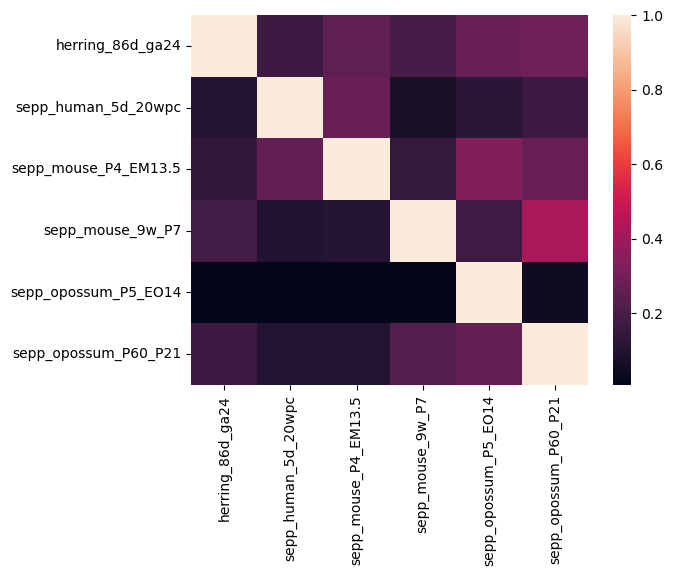

In [132]:
sns.heatmap(overlaps)

In [6]:
def gene_search_agewise(search_terms, dges_search, species, dataset):
    # Read in GMT file
    import csv
    if species == 'human':
        go_file_bp = '/group/ll005/cmcphan/notebooks/analysis/c5.go.bp.v2024.1.Hs.symbols.gmt'
        go_file_mf = '/group/ll005/cmcphan/notebooks/analysis/c5.go.mf.v2024.1.Hs.symbols.gmt'
    elif species == 'mouse':
        go_file_bp = '/group/ll005/cmcphan/notebooks/analysis/m5.go.bp.v2024.1.Mm.symbols.gmt'
        go_file_mf = '/group/ll005/cmcphan/notebooks/analysis/m5.go.mf.v2024.1.Mm.symbols.gmt'
    else:
        raise ValueError("Species must be either 'human' or 'mouse'")
    GO_terms = {}
    with open( go_file_bp, 'r') as f:
        reader = csv.reader( f, delimiter='\t')
        for row in reader:
            GO_terms[row[1]] = np.array( row[2:])
    with open( go_file_mf, 'r') as f:
        reader = csv.reader( f, delimiter='\t')
        for row in reader:
            GO_terms[row[1]] = np.array( row[2:])

    keys = GO_terms.keys()
    # Check through keys in dictionary and record any that contain any of the substrings set in search_terms
    interesting_terms = [k for k in keys if any(t.upper() in k for t in search_terms)]
    
    interesting_genes = {} # Find gene sets we're interested in comparing
    for term in interesting_terms:
        key = term.split('/')[-1] # Get just the term rather than the whole URL for easier reading
        interesting_genes[key] = GO_terms[term]
    
    interesting_genes_list = []
    for gene_set in interesting_genes:
        interesting_genes_list.extend(interesting_genes[gene_set])
    interesting_genes_list = np.unique(interesting_genes_list).tolist()
    interesting_genes_list = [g.upper() for g in interesting_genes_list]
 
    for dge in dges_search:
        # Add capitalized gene symbols to new column for comparisons
        if dataset == 'sepp':
            dge['gene_symbol'] = [sepp_id_to_symbol[g].upper() if sepp_id_to_symbol[g] is not None else g for g in dge.index.tolist()] 
        elif dataset == 'herring':
            dge['gene_symbol'] = [g.upper() for g in dge.index.tolist()]
        search_genes = []
        degs = dge.sort_values(by='pvalue').dropna().query('padj <= 0.05').query('log2FoldChange >= 1 | log2FoldChange <= -1')
        degs = degs.loc[degs['gene_symbol'].isin(common_genes)] # Limit to only common genes
        degs_list = degs['gene_symbol'].values.tolist()
        degs_search_related = []
        filtered_genes = [g.upper() for g in interesting_genes_list if g in degs_list]
        if len(filtered_genes) > 0:
            degs_search_related.extend(filtered_genes)
        search_genes = np.unique(degs_search_related).tolist()
        degs_up = dge.loc[dge['gene_symbol'].isin(search_genes)].query('log2FoldChange > 0')
        degs_down = dge.loc[dge['gene_symbol'].isin(search_genes)].query('log2FoldChange < 0')
        search_results = {'up': degs_up, 'down': degs_down}
    return search_results

In [135]:
search_results = {}
search_terms = ['HISTONE', 'METHYLATION', 'METHYLTRANSFERASE', 'ACETYLATION', 'ACETYLTRANSFERASE', 'EPIGENETIC']
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/']
comps = ['herring_86d_ga24', 'sepp_human_5d_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P5_EO14', 'sepp_opossum_P60_P21']
species = ['human', 'human', 'mouse', 'mouse', 'human', 'human']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp', 'sepp']
for p, s, d, c in zip(paths, species, datasets, comps):
    dges_search = []
    dges_search.append(pd.read_csv(str(p+c), index_col=0))
    res = gene_search_agewise(search_terms, dges_search, s, d)
    search_results[c] = res
search_results

{'herring_86d_ga24': {'up':             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
  ICMT        5.999880        1.912337  0.462999  4.130322  3.622550e-05   
  SFPQ      139.857854        1.005664  0.146614  6.859248  6.922418e-12   
  ZMPSTE24   15.325746        1.303468  0.312541  4.170546  3.038701e-05   
  PRKAA2     61.502984        1.215151  0.208274  5.834388  5.398835e-09   
  DBT        19.587327        1.508792  0.244801  6.163331  7.123053e-10   
  DPH5       12.180643        1.230016  0.241994  5.082831  3.718510e-07   
  DNMT3A     81.512200        1.078040  0.118753  9.078032  1.105561e-19   
  THADA      73.613942        1.193931  0.226329  5.275206  1.326067e-07   
  APLF       12.187629        2.655197  0.473020  5.613284  1.985222e-08   
  METTL8     33.136351        1.117503  0.250630  4.458774  8.242986e-06   
  HDAC11     12.011885        1.107625  0.316513  3.499460  4.662007e-04   
  ZCWPW2     23.670002        1.031982  0.253607  4.069216  4.

In [137]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
up = search_results['herring_86d_ga24']['up']['gene_symbol'].values.tolist()
down = search_results['herring_86d_ga24']['down']['gene_symbol'].values.tolist()
for comp in ['sepp_human_5d_20wpc']:
    up = [g for g in up if g in search_results[comp]['up']['gene_symbol'].values.tolist()]
    down = [g for g in down if g in search_results[comp]['down']['gene_symbol'].values.tolist()]
common_up = up
common_down = down
up = [g for g in up if g not in down]
down = [g for g in down if g not in up]
unique_up = up
unique_down = down

In [138]:
common_up

[]

In [139]:
common_down

['KDM1A', 'ING2', 'ACAT2', 'CHD7', 'MYC']

In [140]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
up = search_results['herring_86d_ga24']['up']['gene_symbol'].values.tolist()
down = search_results['herring_86d_ga24']['down']['gene_symbol'].values.tolist()
for comp in ['sepp_mouse_P4_EM13.5']:
    up = [g for g in up if g in search_results[comp]['up']['gene_symbol'].values.tolist()]
    down = [g for g in down if g in search_results[comp]['down']['gene_symbol'].values.tolist()]
common_up = up
common_down = down
up = [g for g in up if g not in down]
down = [g for g in down if g not in up]
unique_up = up
unique_down = down

In [141]:
common_up

['DNMT3A', 'ZCWPW2', 'METTL24', 'NACC2', 'PRKCB', 'PEMT']

In [142]:
common_down

['KDM1A',
 'KDM5B',
 'HNRNPU',
 'KDM3A',
 'SMARCA5',
 'SOX4',
 'HDAC2',
 'ACAT2',
 'CBX3',
 'PHF6',
 'CHD7',
 'LHX2',
 'SUDS3',
 'PAFAH1B3',
 'PAXBP1']

In [143]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
up = search_results['herring_86d_ga24']['up']['gene_symbol'].values.tolist()
down = search_results['herring_86d_ga24']['down']['gene_symbol'].values.tolist()
for comp in ['sepp_mouse_9w_P7']:
    up = [g for g in up if g in search_results[comp]['up']['gene_symbol'].values.tolist()]
    down = [g for g in down if g in search_results[comp]['down']['gene_symbol'].values.tolist()]
common_up = up
common_down = down
up = [g for g in up if g not in down]
down = [g for g in down if g not in up]
unique_up = up
unique_down = down

In [144]:
common_up

['ICMT',
 'SFPQ',
 'ZMPSTE24',
 'PRKAA2',
 'HDAC11',
 'NAT8L',
 'NACC2',
 'METTL25',
 'CDYL2',
 'AKAP8L']

In [145]:
common_down

['SOX4', 'ACAT2', 'ATAD2', 'PAX6', 'CCDC38', 'CBX1', 'INSM1', 'PAFAH1B3']

In [146]:
search_results = {}
search_terms = ['OXYGEN_LEVELS', 'REACTIVE_OXYGEN_SPECIES', 'OXYGEN_RADICAL', 'OXYGEN_HOMEOSTASIS']
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/']
comps = ['herring_86d_ga24', 'sepp_human_5d_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P5_EO14', 'sepp_opossum_P60_P21']
species = ['human', 'human', 'mouse', 'mouse', 'human', 'human']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp', 'sepp']
for p, s, d, c in zip(paths, species, datasets, comps):
    dges_search = []
    dges_search.append(pd.read_csv(str(p+c), index_col=0))
    res = gene_search_agewise(search_terms, dges_search, s, d)
    search_results[c] = res
search_results

{'herring_86d_ga24': {'up':              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
  OPRD1        5.124409        2.289028  0.489898   4.672454  2.976220e-06   
  CHRNB2       7.032674        2.210682  0.348840   6.337230  2.339332e-10   
  GPR37L1     20.933002        2.737470  0.428783   6.384279  1.722073e-10   
  ADORA1      12.683398        1.092248  0.366686   2.978699  2.894753e-03   
  RYR2       369.318547        1.117753  0.205493   5.439387  5.346411e-08   
  DNMT3A      81.512200        1.078040  0.118753   9.078032  1.105561e-19   
  KCNK3       15.682940        1.168881  0.403974   2.893460  3.810224e-03   
  ERCC3       23.836693        1.384078  0.207323   6.675958  2.456225e-11   
  NFE2L2      98.858542        1.083722  0.248371   4.363320  1.281033e-05   
  ATG7       152.997028        1.342896  0.233879   5.741838  9.365423e-09   
  PPARG       20.885770        1.484862  0.505814   2.935590  3.329139e-03   
  SCAP        33.494700        1.21654

In [147]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
up = search_results['herring_86d_ga24']['up']['gene_symbol'].values.tolist()
down = search_results['herring_86d_ga24']['down']['gene_symbol'].values.tolist()
for comp in ['sepp_mouse_P4_EM13.5']:
    up = [g for g in up if g in search_results[comp]['up']['gene_symbol'].values.tolist()]
    down = [g for g in down if g in search_results[comp]['down']['gene_symbol'].values.tolist()]
common_up = up
common_down = down
up = [g for g in up if g not in down]
down = [g for g in down if g not in up]
unique_up = up
unique_down = down

In [148]:
common_up

['GPR37L1',
 'RYR2',
 'DNMT3A',
 'NFE2L2',
 'PPARG',
 'PPARGC1B',
 'MAP3K5',
 'KCND2',
 'GRIN1']

In [149]:
common_down

['PXDN', 'VEGFA', 'HDAC2']

In [150]:
# Look for commonalities in epigenetic DEGs across stages/species at birth
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
up = search_results['herring_86d_ga24']['up']['gene_symbol'].values.tolist()
down = search_results['herring_86d_ga24']['down']['gene_symbol'].values.tolist()
for comp in ['sepp_mouse_9w_P7']:
    up = [g for g in up if g in search_results[comp]['up']['gene_symbol'].values.tolist()]
    down = [g for g in down if g in search_results[comp]['down']['gene_symbol'].values.tolist()]
common_up = up
common_down = down
up = [g for g in up if g not in down]
down = [g for g in down if g not in up]
unique_up = up
unique_down = down

In [151]:
common_up

['CHRNB2',
 'ADORA1',
 'RYR2',
 'PPARGC1B',
 'GRIN1',
 'ERCC6',
 'LRRK2',
 'SLC8A3',
 'RORA']

In [152]:
common_down

['ECT2', 'ATP7A', 'DDIT4']

In [9]:
search_results = {}
search_terms = ['TRANSCRIPTION_FACTOR']
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/']
comps = ['herring_86d_ga24', 'sepp_human_5d_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P5_EO14', 'sepp_opossum_P60_P21']
species = ['human', 'human', 'mouse', 'mouse', 'human', 'human']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp', 'sepp']
for p, s, d, c in zip(paths, species, datasets, comps):
    dges_search = []
    dges_search.append(pd.read_csv(str(p+c), index_col=0))
    res = gene_search_agewise(search_terms, dges_search, s, d)
    search_results[c] = res
search_results

{'herring_86d_ga24': {'up':           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
  HES5     26.662628        1.771323  0.314972  5.623744  1.868625e-08   
  PAQR7    11.092738        1.721058  0.246442  6.983627  2.876552e-12   
  OPRD1     5.124409        2.289028  0.489898  4.672454  2.976220e-06   
  NFYC     44.423488        1.513162  0.233313  6.485536  8.841677e-11   
  HIVEP3  375.632421        1.031495  0.176190  5.854456  4.785744e-09   
  ...            ...             ...       ...       ...           ...   
  NFIC     61.928626        1.091258  0.280724  3.887300  1.013653e-04   
  ZBTB7A   36.124713        2.413524  0.251726  9.587900  8.989634e-22   
  CC2D1A   52.329003        1.606976  0.231698  6.935644  4.043744e-12   
  CRTC1    59.323270        1.195426  0.140501  8.508308  1.764900e-17   
  TEF      12.602107        1.761535  0.288219  6.111799  9.851452e-10   
  
                  padj gene_symbol  
  HES5    2.335223e-07        HES5  
  PAQR7  

In [16]:
up = search_results['herring_86d_ga24']['up']['gene_symbol'].values.tolist()
down = search_results['herring_86d_ga24']['down']['gene_symbol'].values.tolist()
for comp in ['sepp_mouse_P4_EM13.5']:
    up = [g for g in up if g in search_results[comp]['up']['gene_symbol'].values.tolist()]
    down = [g for g in down if g in search_results[comp]['down']['gene_symbol'].values.tolist()]
common_up_birth = up
common_down_birth = down

In [17]:
common_up_birth

['HIVEP3',
 'DNMT3A',
 'NPAS2',
 'NFE2L2',
 'PPARG',
 'THRB',
 'RARB',
 'MED12L',
 'NR3C1',
 'PPARGC1B',
 'ESR1',
 'AR',
 'ZFPM2',
 'NACC2',
 'MKX',
 'FANK1',
 'MYRFL',
 'PRKCB']

In [19]:
common_down_birth

['KDM1A',
 'HNRNPU',
 'KDM3A',
 'ELF2',
 'SOX4',
 'POU3F2',
 'HDAC2',
 'CBX3',
 'HBP1',
 'COPS5',
 'LHX2',
 'NFATC4']

In [20]:
up = search_results['herring_86d_ga24']['up']['gene_symbol'].values.tolist()
down = search_results['herring_86d_ga24']['down']['gene_symbol'].values.tolist()
for comp in ['sepp_mouse_9w_P7']:
    up = [g for g in up if g in search_results[comp]['up']['gene_symbol'].values.tolist()]
    down = [g for g in down if g in search_results[comp]['down']['gene_symbol'].values.tolist()]
common_up_eye_opening = up
common_down_eye_opening = down

In [21]:
common_up_eye_opening

['HIVEP3',
 'HDAC11',
 'MXD4',
 'NR3C1',
 'PPARGC1B',
 'ETV1',
 'MID2',
 'NACC2',
 'ARRB1',
 'RORA',
 'MAF',
 'ZBTB4',
 'HLF',
 'NFIC',
 'CRTC1',
 'TEF']

In [22]:
common_down_eye_opening

['GLI2',
 'ID4',
 'SOX4',
 'HMGN3',
 'POU3F2',
 'HEY1',
 'PAX6',
 'PHB2',
 'MEIS2',
 'INSM1',
 'ID1']

I think given the number of common DEGs between the human samples at birth and the mouse at birth/eye-opening that the appearance of greater similarity with eye-opening is simply an artifact of the data - we don't have a good comparison for the opossum at birth and so can't really say a whole lot about it. Similarly we're missing the mouse at eye opening in the cell type controlled samples so it's difficult to say much about that either. Overall I think the challenges with the data prevent us from making much of a conclusion about similarities/differences between birth and eye opening, it's just unfortunate that the gaps were where they were. Something interesting might still come from looking at the differences in function between the common genes at birth/eye-opening above.

Look at differences in common genes expressed at birth/eye-opening

In [30]:
# Common at birth but not at eye opening
[g for g in common_up_birth if g not in common_up_eye_opening]

['DNMT3A',
 'NPAS2',
 'NFE2L2',
 'PPARG',
 'THRB',
 'RARB',
 'MED12L',
 'ESR1',
 'AR',
 'ZFPM2',
 'MKX',
 'FANK1',
 'MYRFL',
 'PRKCB']

DNMT3A: genome wide methylator, required for proper development, sets up de novo methylation patterns\
NPAS3: may regulate genes involved in neurogenesis\
NFE2L2: response to oxidative stress\
PPARG: key regulator of adipocyte differentiation and glucose homeostasis\
THRB: thyroid hormone receptor\
RARB: receptor for retinoic acid which mediates cellular signalling in embryonic morphogenesis\
MED12L: component of mediator complex required for transcriptional coactivation of RNA-polII dependent genes\
ESR1: nuclear hormone receptor, involved in regulating gene expression, cellular proliferation and differentiation\
AR: androgen receptor, see ESR1\
ZFPM2: zinc finger protein, acts as regulator in cardiac tissues\
MKX: regulator of cell adhesion\
FANK1: regulator of apoptosis\
MYRFL: predicted regulator of DNA-templated transcription\
PRKCB: involved in a lot of processes, including oxidative stress induced apoptosis

In [31]:
# Common at birth but not at eye opening
[g for g in common_down_birth if g not in common_down_eye_opening]

['KDM1A',
 'HNRNPU',
 'KDM3A',
 'ELF2',
 'HDAC2',
 'CBX3',
 'HBP1',
 'COPS5',
 'LHX2',
 'NFATC4']

KDM1A: histone demethylase implicated in repression of neuronal genes\
HNRNPU: DNA/RNA binding protein involved in nuclear chromatin reorganization, telomere length regulation, transcription, etc.\
KDM3A: histone demethylase implicated in postive regulation of DNA-templated transcription\
ELF2: regulator of DNA-templated transcription\
HDAC2: histone deacetylase important in cell cycle progression\
CBX3: component of heterochromatin, epigenetic repressor\
HBP1: repressor involved in cell cycle regulation, negative regulation of reactive oxygen species biosynthetic process\
COPS5: subunit of COP9 signalosome complex, involved in a variety of cellular and developmental processes\
LHX2: transcriptional activator involved in cell differentiation\
NFATC4: implicated in a variety of processes including regulation of adult hippocampal neurogenesis

In [28]:
# Common at eye opening but not at birth
[g for g in common_up_eye_opening if g not in common_up_birth]

['HDAC11',
 'MXD4',
 'ETV1',
 'MID2',
 'ARRB1',
 'RORA',
 'MAF',
 'ZBTB4',
 'HLF',
 'NFIC',
 'CRTC1',
 'TEF']

HDAC11: histone deacetylase, repressor involved in transcriptional regulation, cell cycle progression\
MXD4: transcriptional repressor, tumour suppressor, regulator of cell growth in differentiating tissues\
ETV1: transcriptional activator involved in cell growth, proliferation, differentiation\
MID2: E3 ubuitin ligase involved in microtubule stabilization\
ARRB1: mediates G-protein coupled receptor activity, involved in both desensitization and resensitization\
RORA: regulator of embryonic development, cellular differentiation, circadian rhythm\
MAF: transcriptional activator or repressor involved in a variety of processes\
ZBTB4: repressor involved in DNA damage response\
HLF: transcriptional activator implicated in B-cell leukaemias\
NFIC: transcription factor and replication factor for adenovirus type 2\
CRTC1: transcriptional coactivator of CREB1, may be required for dendritic growth in cortical neurons\
TEF: binds and transactivates thyroid stimulating hormone subunit beta promoter\

In [29]:
# Common at eye opening but not at birth
[g for g in common_down_eye_opening if g not in common_down_birth]

['GLI2', 'ID4', 'HMGN3', 'HEY1', 'PAX6', 'PHB2', 'MEIS2', 'INSM1', 'ID1']

GLI2: transcriptional regulator of hedgehog pathway, required for normal embryonic development\
ID4: inhibitor of other transcription factors, regulates cell growth, senescence, apoptosis\
HMGN3: binds to nucleosomes, regulates chromatin structure and chromatin-related processes\
HEY1: transcriptional repressor which promotes maintenance of neuronal precursor cells\
PAX6: important in development of neural tissues, regulates specification of ventral neuron subtypes\
PHB2: positive regulation of cell cycle phase transition, regulation of DNA-templated transcription\
MEIS2: may contribute to developmental programs\
INSM1: key role in neurogenesis\
ID1: inhibitor of other transcription factors, may be involved in regulating cell growth, senescence, differentiation, apoptosis

---
### Figures

In [6]:
dges = {}
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/herring_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/sepp_human_infancy_fetal_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/sepp_mouse_fetal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_neonatal_late_early_',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/sepp_opossum_adolescence_infancy_']
datasets = ['herring', 'sepp', 'sepp', 'sepp', 'sepp']
comps = ['herring_human_birth', 'sepp_human_birth', 'sepp_mouse_birth', 'sepp_opossum_neonatal', 'sepp_opossum_eye_opening']
cell_types = ['PN', 'IN', 'Oligo', 'Astro']
for p, d, c in zip(paths, datasets, comps):
    comp_dges = {}
    for t in cell_types:
        try:
            dge = pd.read_csv(str(p+t), index_col=0)
        except:
            continue
        if d == 'sepp':
            dge['gene_symbol'] = [sepp_id_to_symbol[g].upper() if sepp_id_to_symbol[g] is not None else g for g in dge.index.tolist()]
        elif d == 'herring':
            dge['gene_symbol'] = [g.upper() for g in dge.index.to_list()]
        dge = dge.query('padj <= 0.05')
        dge_up = dge.query('log2FoldChange >= 1')
        dge_down = dge.query('log2FoldChange <= -1')
        comp_dges[t] = {'up': dge_up, 'down': dge_down}
    dges[c] = comp_dges
dges

{'herring_human_birth': {'PN': {'up':                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
   RP4-669L17.10   528.523909        1.825056  0.640942  2.847458  0.004407   
   PLEKHN1          35.676728        3.691518  1.188071  3.107152  0.001889   
   AGRN           2154.651320        1.556038  0.547076  2.844278  0.004451   
   SCNN1D          216.113398        2.174325  0.546060  3.981842  0.000068   
   MMP23B           44.252895        2.616680  0.666093  3.928403  0.000086   
   ...                    ...             ...       ...       ...       ...   
   SUMO3          2004.991223        1.669406  0.606699  2.751619  0.005930   
   LINC00334        38.465037        2.711859  0.958872  2.828176  0.004681   
   FTCD            240.502939        1.859192  0.532670  3.490325  0.000482   
   S100B           109.835370        2.548212  0.908626  2.804467  0.005040   
   AC145212.1       29.014021        3.339389  1.057765  3.157024  0.001594   
   
             

In [7]:
summary = pd.DataFrame(columns=['Comparison', 'Cell Type', 'Direction of Change', 'DEGs'])
for comp in comps:
    for cell_type in ['PN', 'IN', 'Oligo', 'Astro']:
        try:
            degs = dges[comp][cell_type]
        except:
            degs = None
        if degs == None:
            summary.loc[len(summary)] = [comp, cell_type, 'Up', 0]
            summary.loc[len(summary)] = [comp, cell_type, 'Down', 0]
        else:
            summary.loc[len(summary)] = [comp, cell_type, 'Up', len(dges[comp][cell_type]['up'])]
            summary.loc[len(summary)] = [comp, cell_type, 'Down', len(dges[comp][cell_type]['down'])]
summary

,Comparison,Cell Type,Direction of Change,DEGs
0,herring_human_birth,PN,Up,1975
1,herring_human_birth,PN,Down,1247
2,herring_human_birth,IN,Up,1422
3,herring_human_birth,IN,Down,810
4,herring_human_birth,Oligo,Up,111
5,herring_human_birth,Oligo,Down,79
6,herring_human_birth,Astro,Up,337
7,herring_human_birth,Astro,Down,361
8,sepp_human_birth,PN,Up,964
9,sepp_human_birth,PN,Down,1611


In [8]:
import matplotlib.pyplot as plt

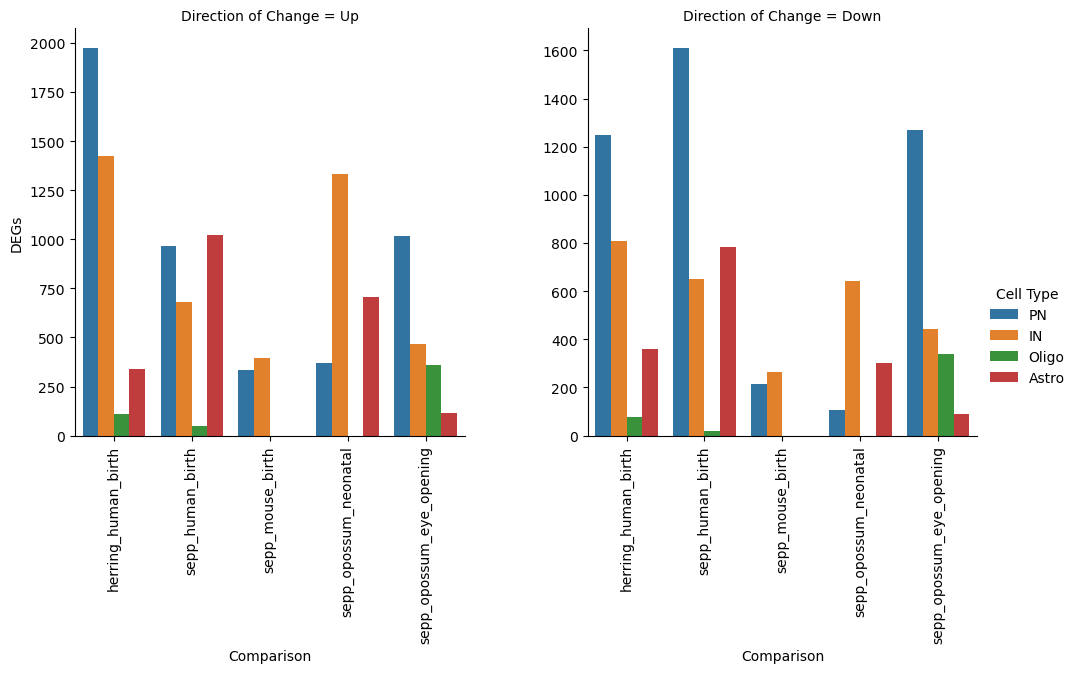

In [12]:
g = sns.catplot(data=summary, kind='bar', col='Direction of Change', x='Comparison', y='DEGs', hue='Cell Type', 
            errorbar=None, sharex=False, sharey=False)
g.set_xticklabels(rotation=90)

In [13]:
g.savefig(str(FIG_PATH+'deg_counts.svg'), dpi=300, bbox_inches='tight')

In [62]:
# Colours for cell types
for i in range(0, 4):
    print(g.legend.legend_handles[i].get_facecolor())

(0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1)
(0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1)
(0.22941176470588232, 0.5705882352941177, 0.22941176470588232, 1)
(0.7534313725490196, 0.23872549019607847, 0.24166666666666664, 1)


In [79]:
herring_human.obs['cell_type'].values

['PN', 'PN', 'IN', 'PN', 'Non-Neu', ..., 'IN', 'IN', 'Non-Neu', 'PN', 'IN']
Length: 154748
Categories (4, object): ['IN', 'Non-Neu', 'PN', 'Poor-Quality']

In [81]:
herring_human.obs.loc[herring_human.obs['age']=='ga34', 'stage_id'] = 'Neonatal'
herring_human.obs['cell_type'] = herring_human.obs['cell_type'].cat.set_categories(['IN', 'Non-Neu', 'PN', 'Poor-Quality', 'Vas'])
herring_human.obs.loc[herring_human.obs['major_clust']=='Vas', 'cell_type'] = 'Vas'
herring_human.obs['cell_type'] = herring_human.obs['cell_type'].cat.set_categories(['IN', 'Non-Neu', 'PN', 'Poor-Quality', 'Vas', 'Oligo', 'Astro'])
herring_human.obs.loc[herring_human.obs['major_clust'].isin(['Oligo', 'OPC']), 'cell_type'] = 'Oligo' # Group oligodendrocytes and precursors together
herring_human.obs.loc[herring_human.obs['major_clust'] == 'Astro', 'cell_type'] = 'Astro'
herring_human.obs[['cell_type', 'major_clust']].drop_duplicates()

,cell_type,major_clust
AAACCTGAGAGTCGGT-RL1612_34d_v2,PN,L4_RORB
AAACCTGAGCCGCCTA-RL1612_34d_v2,PN,L2-3_CUX2
AAACCTGAGTCGAGTG-RL1612_34d_v2,IN,SST
AAACCTGCAAGGACTG-RL1612_34d_v2,Astro,Astro
AAACCTGCAGGCGATA-RL1612_34d_v2,PN,L5-6_TLE4
AAACCTGCAGTGGGAT-RL1612_34d_v2,PN,L5-6_THEMIS
AAACCTGGTACTCAAC-RL1612_34d_v2,IN,VIP
AAACCTGGTTACGCGC-RL1612_34d_v2,Oligo,OPC
AAACGGGCAATGGATA-RL1612_34d_v2,IN,PV
AAACGGGTCTATCGCC-RL1612_34d_v2,IN,PV_SCUBE3


In [82]:
sepp_human.obs['broad_cell_type'] = pd.Series(dtype='category')
sepp_human.obs['broad_cell_type'] = sepp_human.obs['broad_cell_type'].cat.set_categories(['PN', 'IN', 'Oligo', 'Astro'])
sepp_human.obs.loc[sepp_human.obs['cell_type'].isin(['GC', 'UBC', 'NTZ_neuroblast']), 'broad_cell_type'] = 'PN'
sepp_human.obs.loc[sepp_human.obs['cell_type'].isin(['Purkinje', 'interneuron', 'VZ_neuroblast']), 'broad_cell_type'] = 'IN'
sepp_human.obs.loc[sepp_human.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Oligo'
sepp_human.obs.loc[sepp_human.obs['cell_type'] == 'astroglia', 'broad_cell_type'] = 'Astro'

In [83]:
sepp_mouse.obs['broad_cell_type'] = pd.Series(dtype='category')
sepp_mouse.obs['broad_cell_type'] = sepp_mouse.obs['broad_cell_type'].cat.set_categories(['PN', 'IN', 'Oligo', 'Astro'])
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'].isin(['GC', 'UBC', 'NTZ_neuroblast']), 'broad_cell_type'] = 'PN'
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'].isin(['Purkinje', 'interneuron', 'VZ_neuroblast']), 'broad_cell_type'] = 'IN'
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Oligo'
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'] == 'astroglia', 'broad_cell_type'] = 'Astro'

In [84]:
sepp_opossum.obs['broad_cell_type'] = pd.Series(dtype='category')
sepp_opossum.obs['broad_cell_type'] = sepp_opossum.obs['broad_cell_type'].cat.set_categories(['PN', 'IN', 'Oligo', 'Astro'])
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'].isin(['GC', 'UBC', 'NTZ_neuroblast']), 'broad_cell_type'] = 'PN'
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'].isin(['Purkinje', 'interneuron', 'VZ_neuroblast']), 'broad_cell_type'] = 'IN'
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Oligo'
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'] == 'astroglia', 'broad_cell_type'] = 'Astro'

In [85]:
for data in [sepp_human, sepp_mouse, sepp_opossum]:
    data.obs['broad_cell_type'] = ['None' if g is np.nan else g for g in data.obs['broad_cell_type']]

In [86]:
herring_human.obs['broad_cell_type'] = herring_human.obs['cell_type']

In [97]:
summary = pd.DataFrame(columns=['Dataset', 'Stage', 'Cell Type', 'Nuclei', 'row'])
for data, d in zip([herring_human, sepp_human, sepp_mouse, sepp_opossum], ['Herring', 'Sepp Human', 'Sepp Mouse', 'Sepp Opossum']):
    if d in ['Herring', 'Sepp Human']:
        row = 1
    else:
        row = 2
    for stage in set(data.obs['stage_id'].values.tolist()):
        if stage == 'None':
            continue
        filtered = data[data.obs['stage_id'] == stage]
        for cell_type in ['PN', 'IN', 'Oligo', 'Astro']:
            summary.loc[len(summary)] = [d, stage, cell_type, len(filtered[filtered.obs['broad_cell_type'] == cell_type]), row]
summary

,Dataset,Stage,Cell Type,Nuclei,row
0,Herring,Adult,PN,4853,1
1,Herring,Adult,IN,3323,1
2,Herring,Adult,Oligo,11717,1
3,Herring,Adult,Astro,3334,1
4,Herring,Adolescence,PN,4364,1
...,...,...,...,...,...
87,Sepp Opossum,Neonatal,Astro,6460,2
88,Sepp Opossum,Childhood,PN,4423,2
89,Sepp Opossum,Childhood,IN,974,2
90,Sepp Opossum,Childhood,Oligo,147,2


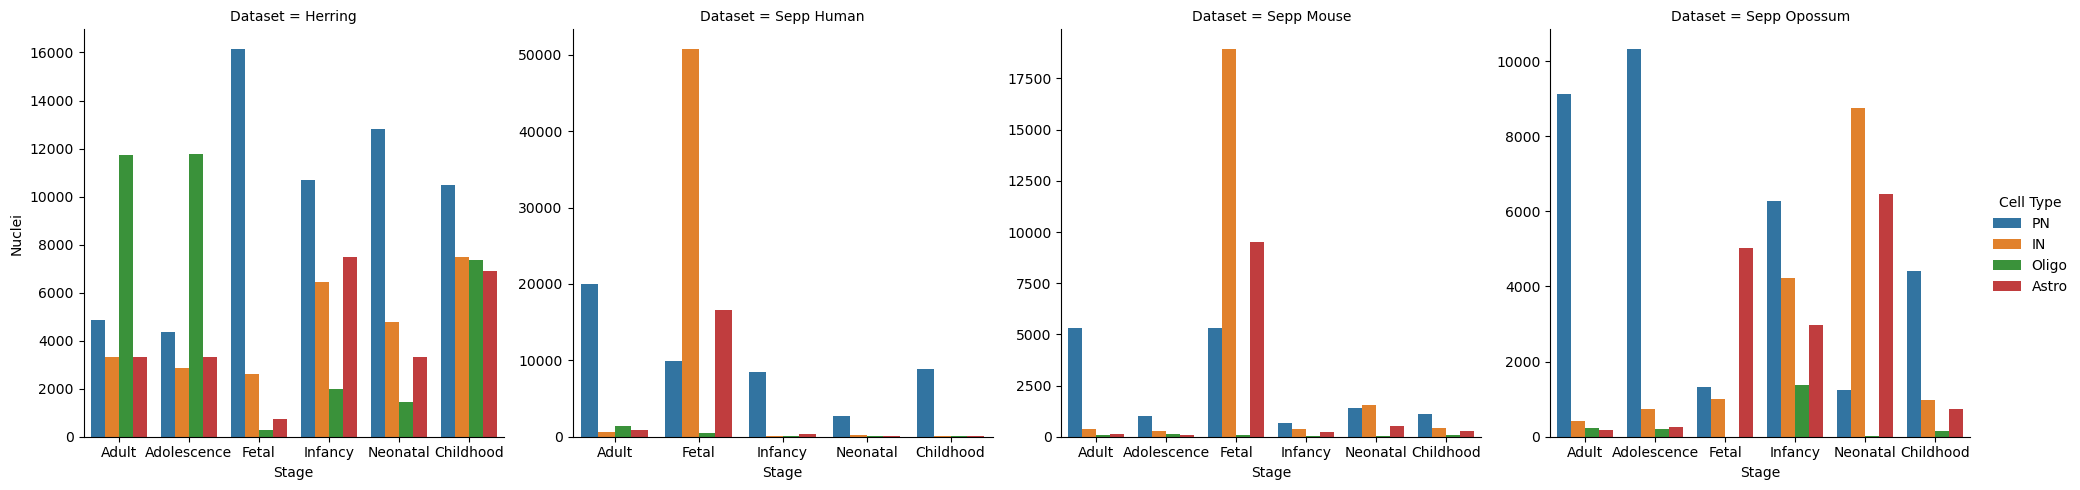

In [99]:
g = sns.catplot(data=summary, kind='bar', col='Dataset', x='Stage', y='Nuclei', hue='Cell Type', 
            errorbar=None, sharex=False, sharey=False)
#g.set_xticklabels(rotation=90)

In [100]:
g.savefig(str(FIG_PATH+'nuclei_per_stage.svg'), dpi=300, bbox_inches='tight')